## imports


In [ ]:
# !ls /datasets/aurora

In [1]:
bash ssh_keys/load_ssh3.sh

SyntaxError: invalid syntax (815047914.py, line 1)

In [ ]:
! sudo apt remove -y python3-numpy python3-scipy
!pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu124
!pip install cdsapi dask xarray netcdf4 matplotlib microsoft-aurora boto3 awscli
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!pip install scikit-learn
!pip install imblearn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cudnn-license fonts-lyx libabsl20210324 libaec0 libboost-dev
  libboost1.74-dev libc-ares2 libdouble-conversion3 libgif7 libhdf5-103-1
  libhdf5-hl-100 libimagequant0 libjs-jquery-ui liblbfgsb0 liblzf1 libmagma2
  libopenblas-dev libopenblas-pthread-dev libopenblas0 libqhull-r8.0 libraqm0
  libsz2 libwebpdemux2 libxsimd-dev python-matplotlib-data python3-absl
  python3-appdirs python3-astunparse python3-beniget python3-bleach
  python3-brotli python3-bs4 python3-cycler python3-einops python3-flatbuffers
  python3-fs python3-fsspec python3-gast python3-grpcio python3-html5lib
  python3-joblib python3-kiwisolver python3-lxml python3-lz4 python3-mpmath
  python3-namex python3-networkx python3-olefile python3-optree python3-pasta
  python3-pil python3-pil.imagetk python3-protobuf python3-soupsieve
  python3-sympy 

tthe next two boxes are used for using aws cli 

In [5]:
!aws --version

aws-cli/1.36.22 Python/3.10.12 Linux/6.8.0-1013-nvidia-64k botocore/1.35.81


In [ ]:
# see awsid

In [ ]:
import xarray as xr
from tqdm import tqdm
from aurora import Batch, Metadata
import os
import glob
import re
import boto3
from io import BytesIO
import io
import pandas as pd
import torch.nn.functional as F
from aurora import Aurora
from aurora.normalisation import locations, scales
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import torch
import sklearn
import numpy as np
import gc
# from netCDF4 import Dataset
# import h5py
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

True

## importing data

In [ ]:
# see awsid for missing line

# bucket_name = 'globfire-gooddata'
# compression_settings = {'zlib': True, 'complevel': 3}

# surf_comb = xr.open_mfdataset(surf_files, combine='nested')
# encoding_surf = {var: compression_settings for var in surf_comb.data_vars}
# surf_comb.to_netcdf("surf_comb.nc", encoding=encoding_surf)
# s3.upload_file("surf_comb.nc", bucket_name, "surf_comb.nc")

code for joinging 3 days worth of data together to feed into aurora

In [ ]:
download_path = "datasets/aurora"
surf_path = f"../{download_path}/fle"
atmos_path = f"../{download_path}/atmospheric"

static_vars_ds = xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4")
atmos_files = glob.glob(f"../{download_path}/atmospheric/*/*.nc") 
atmos_files_2021 = [f for f in atmos_files if int(f.split('/')[-2]) <= 202112]
surf_files = glob.glob(f"../{download_path}/fle/*.nc") 

In [ ]:
starty = 2015     ## start of 2015 to end of 2021
endy = 2021           
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-12-31', freq='D')

download_path = "datasets/aurora"
surf_path = f"../{download_path}/fle"
atmos_path = f"../{download_path}/atmospheric"

atmos_files = glob.glob(f"../{download_path}/atmospheric/*/*.nc") 
# atmos_files = glob.glob(f"../{download_path}/atmospheric/(201[0-9][0-9]{2}|202(0|1)[0-9]{2})/*.nc")  
atmos_files_2021 = [f for f in atmos_files if int(f.split('/')[-2]) <= 202112]
surf_files = glob.glob(f"../{download_path}/fle/*.nc") 


days = 3

# ./datasets/aurora/atmospheric/201501/atmospheric_20150111.nc'
#../datasets/aurora/fle/surf_2021-11-17.nc'

In [ ]:
i=0
date_range[i:i + days]

## basic one day batch

In [7]:
variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'lst', 'fire']
date_range = pd.date_range(start=f'{2015}-01-01', end=f'{2015}-1-03', freq='D')
days = 1
for i in tqdm(range(len(date_range) - days + 1), desc = "data loading"):
    date_window = date_range[i:i + days]
    
    atmos_regex = []
    surf_regex = []
    for day in range(days):
        atmos_regex.append( re.compile( rf".*/{date_window[day].strftime('%Y%m')}/atmospheric_{date_window[day].strftime('%Y%m%d')}\.nc$"))
        surf_regex.append( re.compile( rf".*/surf_{date_window[day].strftime('%Y-%m-%d')}\.nc$"))
    
    atmos_filt = [f for f in atmos_files_2021 if any(d.match(f) for d in atmos_regex)]
    surf_filt = [f for f in surf_files if any(d.match(f) for d in surf_regex)]

    print(atmos_filt)
    print(surf_filt)
    
    
    atmos_list = []
    surf_list = []
    
    for day in range(len(atmos_filt)):
        atmos_cur = xr.open_dataset(atmos_filt[day])
        surf_cur = xr.open_dataset(surf_filt[day])
        
        # code for dropping variables. makes code run slower. interpolation so fast that it doest matter. 
        surf_cur = surf_cur.drop_vars([var for var in surf_cur.data_vars if var not in variables_to_keep])

        atmos_list.append(atmos_cur)
        surf_list.append(surf_cur)
    
    atmos_comb = xr.concat(atmos_list, dim="valid_time")
    surf_comb = xr.concat(surf_list, dim="valid_time")
    
static_vars_ds = xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4")

data loading:   0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'atmos_files_2021' is not defined

In [ ]:

i = 1  # Select this time index in the downloaded data.

batch = Batch(
    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None]),
        "10u": torch.from_numpy(surf_comb["u10"].values[[i - 1, i]][None]),
        "10v": torch.from_numpy(surf_comb["v10"].values[[i - 1, i]][None]),
        "msl": torch.from_numpy(surf_comb["msl"].values[[i - 1, i]][None]),
        "fire": torch.from_numpy(surf_comb["fire"].values[[i - 1, i]][None]),
        "lst": torch.from_numpy(surf_comb["lst"].values[[i - 1, i]][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_comb["t"].values[[i - 1, i]][None]),
        "u": torch.from_numpy(atmos_comb["u"].values[[i - 1, i]][None]),
        "v": torch.from_numpy(atmos_comb["v"].values[[i - 1, i]][None]),
        "q": torch.from_numpy(atmos_comb["q"].values[[i - 1, i]][None]),
        "z": torch.from_numpy(atmos_comb["z"].values[[i - 1, i]][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_comb.latitude.values),
        lon=torch.from_numpy(surf_comb.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
    ),
)

In [ ]:
# static_vars_ds = xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4")
# surf_vars_ds = xr.open_dataset(f"../{download_path}/fle/surf_2015-01-04.nc", engine="netcdf4")
# atmos_vars_ds = xr.open_dataset(f"../{download_path}/atmospheric/201501/atmospheric_20150104.nc", engine="netcdf4")


j = i+1  # Select this time index in the downloaded data.

surf_size = (720, 1440)
atmos_size = (720, 1440)

surf_vars={
    # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
    # batch dimension of size one.
    "2t": torch.from_numpy(surf_comb["t2m"].values[[j]][None]),
    "10u": torch.from_numpy(surf_comb["u10"].values[[j]][None]),
    "10v": torch.from_numpy(surf_comb["v10"].values[[j]][None]),
    "msl": torch.from_numpy(surf_comb["msl"].values[[j]][None]),
    "fire": torch.from_numpy(surf_comb["fire"].values[[j]][None]),
    "lst": torch.from_numpy(surf_comb["lst"].values[[j]][None]),
}
static_vars={
    # The static variables are constant, so we just get them for the first time.
    "z": torch.from_numpy(static_vars_ds["z"].values[0]),
    "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
    "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
}
atmos_vars={
    "t": torch.from_numpy(atmos_comb["t"].values[[j]][None]),
    "u": torch.from_numpy(atmos_comb["u"].values[[j]][None]),
    "v": torch.from_numpy(atmos_comb["v"].values[[j]][None]),
    "q": torch.from_numpy(atmos_comb["q"].values[[j]][None]),
    "z": torch.from_numpy(atmos_comb["z"].values[[j]][None]),
}

output_size = (720, 1440)

interpolated_surf_vars = {
    key: F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
    for key, value in surf_vars.items()
}

interpolated_atmos_vars = {
    key: F.interpolate(value.view(-1, 1, 721, 1440), size=atmos_size, mode='bilinear', align_corners=False).view(value.shape[0], value.shape[1], value.shape[2], 720, 1440)
    for key, value in atmos_vars.items()
}

interpolated_static_vars = {
    key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=output_size, mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
    for key, value in static_vars.items()
}


batch2 = Batch(
    surf_vars = interpolated_surf_vars,
    static_vars=interpolated_static_vars,
    atmos_vars=interpolated_atmos_vars,
    metadata=Metadata(
        lat=torch.from_numpy(surf_comb.latitude.values),
        lon=torch.from_numpy(surf_comb.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
    ),
)

## convert to dataset and dataloader 

In [6]:

# using surf_comb is not the best solution
# lstdata = torch.from_numpy(surf_comb["lst"].values[[i - 1, i]][None])
# Normalisation means:
locations["fire"] = 0.0
locations["lst"] = 11484.10859

# Normalisation standard deviations:
scales["fire"] = 1.0
scales["lst"] = 8109.33224

In [7]:
def data_retreive ( atmos_files, surf_files, date_range, days, idx , variables_to_keep = None ):
    date_window = date_range[idx:idx + days]

    atmos_regex = []
    surf_regex = []
    for day in range(days):
        atmos_regex.append( re.compile( rf".*/{date_window[day].strftime('%Y%m')}/atmospheric_{date_window[day].strftime('%Y%m%d')}\.nc$"))
        surf_regex.append( re.compile( rf".*/surf_{date_window[day].strftime('%Y-%m-%d')}\.nc$"))

    atmos_filt = [f for f in atmos_files if any(d.match(f) for d in atmos_regex)]
    surf_filt = [f for f in surf_files if any(d.match(f) for d in surf_regex)]
    atmos_list = []
    surf_list = []

    for day in range(len(atmos_filt)):
        with xr.open_dataset(atmos_filt[day])as atmos_cur, xr.open_dataset(surf_filt[day]) as surf_cur :

            # code for dropping variables. makes code run slower. interpolation so fast that it doest matter. 
            if variables_to_keep is not None:
                surf_cur = surf_cur.drop_vars([var for var in surf_cur.data_vars if var not in variables_to_keep])

            atmos_list.append(atmos_cur.load())
            surf_list.append(surf_cur.load())

    atmos_comb = xr.concat(atmos_list, dim="valid_time")
    surf_comb = xr.concat(surf_list, dim="valid_time")
    return atmos_comb, surf_comb


In [8]:
def feature_label_batch(atmos_comb, surf_comb, static, interpolated_static_vars):
    i = 1  
    batch = Batch(
        surf_vars={
            # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
            # batch dimension of size one.
            "2t": torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None]),
            "10u": torch.from_numpy(surf_comb["u10"].values[[i - 1, i]][None]),
            "10v": torch.from_numpy(surf_comb["v10"].values[[i - 1, i]][None]),
            "msl": torch.from_numpy(surf_comb["msl"].values[[i - 1, i]][None]),
            "fire": torch.from_numpy(surf_comb["fire"].values[[i - 1, i]][None]),
            "lst": torch.from_numpy(surf_comb["lst"].values[[i - 1, i]][None]),
        },
        # static_vars={
        #     # The static variables are constant, so we just get them for the first time.
        #     "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        #     "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        #     "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
        # },
        static_vars=static ,
        atmos_vars={
            "t": torch.from_numpy(atmos_comb["t"].values[[i - 1, i]][None]),
            "u": torch.from_numpy(atmos_comb["u"].values[[i - 1, i]][None]),
            "v": torch.from_numpy(atmos_comb["v"].values[[i - 1, i]][None]),
            "q": torch.from_numpy(atmos_comb["q"].values[[i - 1, i]][None]),
            "z": torch.from_numpy(atmos_comb["z"].values[[i - 1, i]][None]),
        },
        metadata=Metadata(
            lat=torch.from_numpy(surf_comb.latitude.values),
            lon=torch.from_numpy(surf_comb.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
            atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
        )
        # metadata=metadata
    )
    
    j = 2  # Select this time index in the downloaded data.

    surf_size = (720, 1440)
    atmos_size = (720, 1440)

    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_comb["t2m"].values[[j]][None]),
        "10u": torch.from_numpy(surf_comb["u10"].values[[j]][None]),
        "10v": torch.from_numpy(surf_comb["v10"].values[[j]][None]),
        "msl": torch.from_numpy(surf_comb["msl"].values[[j]][None]),
        "fire": torch.from_numpy(surf_comb["fire"].values[[j]][None]),
        # ************** Comment out LST
        "lst": torch.from_numpy(surf_comb["lst"].values[[j]][None]),
    }
    # static_vars={
    #     # The static variables are constant, so we just get them for the first time.
    #     "z": torch.from_numpy(static_vars_ds["z"].values[0]),
    #     "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
    #     "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    # }
    # static_vars=static 
    atmos_vars={
        "t": torch.from_numpy(atmos_comb["t"].values[[j]][None]),
        "u": torch.from_numpy(atmos_comb["u"].values[[j]][None]),
        "v": torch.from_numpy(atmos_comb["v"].values[[j]][None]),
        "q": torch.from_numpy(atmos_comb["q"].values[[j]][None]),
        "z": torch.from_numpy(atmos_comb["z"].values[[j]][None]),
    }

    output_size = (720, 1440)

    interpolated_surf_vars = {
        key: F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
        for key, value in surf_vars.items()
    }

    interpolated_atmos_vars = {
        key: F.interpolate(value.view(-1, 1, 721, 1440), size=atmos_size, mode='bilinear', align_corners=False).view(value.shape[0], value.shape[1], value.shape[2], 720, 1440)
        for key, value in atmos_vars.items()
    }

    # interpolated_static_vars = {
    #     key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=output_size, mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
    #     for key, value in static_vars.items()
    # }


    batch2 = Batch(
        surf_vars = interpolated_surf_vars,
        static_vars=interpolated_static_vars,
        atmos_vars=interpolated_atmos_vars,
        metadata=Metadata(
            lat=torch.from_numpy(surf_comb.latitude.values),
            lon=torch.from_numpy(surf_comb.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[j],),
            atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
        ),
        # metadata=metadata
    )
    return batch, batch2

In [9]:
class AuroraDataset(Dataset):
    def __init__(self, download_path, variables_to_keep , starty, endy):
        """
        Args:
            folder_path (str): Path to the folder containing the daily files.
            transform (callable, optional): A function/transform to apply to the data.
        """
        with xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4") as static_vars_ds:
            self.static={
                # The static variables are constant, so we just get them for the first time.
                "z": torch.from_numpy(static_vars_ds["z"].values[0]),
                "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
                "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
            }
            self.interp_static = {
                key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=(720, 1440), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
                for key, value in self.static.items()
            }
        self.atmos_files = glob.glob(f"../{download_path}/atmospheric/*/*.nc") 
        self.surf_files = glob.glob(f"../{download_path}/fle/*.nc") 
        
        self.window = 3
        self.variables_to_keep = variables_to_keep
        
        self.date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-12-31', freq='D')
        
        # self.file_names = sorted(os.listdir(folder_path))  # Sort to ensure correct order
        # self.transform = transform

    def __len__(self):
        """Returns the total number of files (days)."""
        return len(self.surf_files) - self.window + 1

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the file to load.
        Returns:
            (Tensor, Tensor): Features and labels for the given day.
        """
#         file_path = os.path.join(self.folder_path, self.file_names[idx])
        
        #                       
        atmos, surf = data_retreive(self.atmos_files, self.surf_files, self.date_range
                             , self.window, idx, self.variables_to_keep)
        
        # metadata=Metadata(
        #     lat=torch.from_numpy(surf.latitude.values),
        #     lon=torch.from_numpy(surf.longitude.values),
        #     # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        #     # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        #     # one value for every batch element.
        #     time=(surf.valid_time.values.astype("datetime64[s]").tolist()[1],),
        #     atmos_levels=tuple(int(level) for level in atmos.pressure_level.values),
        # )
        # Assuming the last column is the label
        features, labels = feature_label_batch(atmos, surf, self.static, self.interp_static)
         # = label_batch(atmos, surf, self.interp_static, metadata) # metadata technically wrong for labels

        # Convert to tensors
        return (
            features, labels
        )


In [10]:
def aurora_collate(batch):
    """
    Custom collate function for handling Batch objects as features and labels.

    Args:
        batch (list of tuples): Each tuple contains (features, labels), where
                                features and labels are instances of `Batch`.

    Returns:
        Batched features and labels.
    """
    # Separate features and labels from the batch
    features_list, labels_list = zip(*batch)

    # Function to batch the variables in each component of the `Batch` object
    def collate_batch_components(batch_list, key):
        return {
            var_key: torch.stack([getattr(b, key)[var_key] for b in batch_list])
            for var_key in getattr(batch_list[0], key)}

    # Combine `surf_vars` and `atmos_vars` for features and labels
    batched_features = Batch(
        surf_vars=collate_batch_components(features_list, "surf_vars"),
        static_vars=collate_batch_components(features_list, "static_vars"),
        atmos_vars=collate_batch_components(features_list, "atmos_vars"),
        metadata=Metadata(
            lat=torch.stack([f.metadata.lat for f in features_list]),
            lon=torch.stack([f.metadata.lon for f in features_list]),
            time=[f.metadata.time for f in features_list],
            atmos_levels=[f.metadata.atmos_levels for f in features_list],
        ),
    )

    batched_labels = Batch(
        surf_vars=collate_batch_components(labels_list, "surf_vars"),
        static_vars=collate_batch_components(features_list, "static_vars"),
        atmos_vars=collate_batch_components(labels_list, "atmos_vars"),
        metadata=Metadata(
            lat=torch.stack([l.metadata.lat for l in labels_list]),
            lon=torch.stack([l.metadata.lon for l in labels_list]),
            time=[l.metadata.time for l in labels_list],
            atmos_levels=[l.metadata.atmos_levels for l in labels_list],
        ),
    )

    return features_list[0], labels_list[0]


## run as single block

In [3]:
# Normalisation means:
# locations["fire"] = 0.0
# locations["lst"] = 11484.10859

# Normalisation standard deviations:
# scales["fire"] = 1.0
# scales["lst"] = 8109.33224

# variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'fire']
# variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'lst', 'fire']

def data_retreive ( atmos_files, surf_files, date_range, days, idx , variables_to_keep = None ):
    date_window = date_range[idx:idx + days]
    # print(date_range)
    # print(idx)
    # print(days)
    atmos_regex = []
    surf_regex = []
    for day in range(days):
        # note that no need to look at download path here because its already accounted for when globing inside of aurora dataset
        atmos_regex.append( re.compile( rf".*/{date_window[day].strftime('%Y%m')}/atmospheric_{date_window[day].strftime('%Y%m%d')}\.nc$"))
        surf_regex.append( re.compile( rf".*/surf_{date_window[day].strftime('%Y-%m-%d')}\.nc$"))

    atmos_filt = [f for f in atmos_files if any(d.match(f) for d in atmos_regex)]
    surf_filt = [f for f in surf_files if any(d.match(f) for d in surf_regex)]
    atmos_list = []
    surf_list = []
    # print(atmos_filt)
    # print("surf")
    # print(surf_filt)
    ds = xr.open_dataset(atmos_filt[0]).load()
    ds.close()

    # for day in range(len(atmos_filt)):
    for day in range(days):
        with xr.open_dataset(atmos_filt[day])as atmos_cur, xr.open_dataset(surf_filt[day]) as surf_cur :
            # code for dropping variables. makes code run slower. interpolation so fast that it doest matter. 
            if variables_to_keep is not None:
                surf_cur = surf_cur.drop_vars([var for var in surf_cur.data_vars if var not in variables_to_keep])

            atmos_list.append(atmos_cur.load())
            surf_list.append(surf_cur.load())

    atmos_comb = xr.concat(atmos_list, dim="valid_time")
    surf_comb = xr.concat(surf_list, dim="valid_time")
    return atmos_comb, surf_comb

def feature_label_batch(atmos_comb, surf_comb, static, interpolated_static_vars):
    i = 1  
    batch = Batch(
        surf_vars={
            # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
            # batch dimension of size one.
            "2t": torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None]),
            "10u": torch.from_numpy(surf_comb["u10"].values[[i - 1, i]][None]),
            "10v": torch.from_numpy(surf_comb["v10"].values[[i - 1, i]][None]),
            "msl": torch.from_numpy(surf_comb["msl"].values[[i - 1, i]][None]),
            "fire": torch.from_numpy(surf_comb["fire"].values[[i - 1, i]][None]),
            "lst": torch.from_numpy(surf_comb["lst"].values[[i - 1, i]][None]),
        },
        # static_vars={
        #     # The static variables are constant, so we just get them for the first time.
        #     "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        #     "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        #     "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
        # },
        static_vars=static ,
        atmos_vars={
            "t": torch.from_numpy(atmos_comb["t"].values[[i - 1, i]][None]),
            "u": torch.from_numpy(atmos_comb["u"].values[[i - 1, i]][None]),
            "v": torch.from_numpy(atmos_comb["v"].values[[i - 1, i]][None]),
            "q": torch.from_numpy(atmos_comb["q"].values[[i - 1, i]][None]),
            "z": torch.from_numpy(atmos_comb["z"].values[[i - 1, i]][None]),
        },
        metadata=Metadata(
            lat=torch.from_numpy(surf_comb.latitude.values),
            lon=torch.from_numpy(surf_comb.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
            atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
        )
        # metadata=metadata
    )
    
    # print(np.unique(batch.surf_vars["fire"].cpu().numpy()))
    
    j = 2  # Select this time index in the downloaded data.

    surf_size = (720, 1440)
    atmos_size = (720, 1440)

    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_comb["t2m"].values[[j]][None]),
        "10u": torch.from_numpy(surf_comb["u10"].values[[j]][None]),
        "10v": torch.from_numpy(surf_comb["v10"].values[[j]][None]),
        "msl": torch.from_numpy(surf_comb["msl"].values[[j]][None]),
        "fire": torch.from_numpy(surf_comb["fire"].values[[j]][None]),
        # ************** Comment out LST
        "lst": torch.from_numpy(surf_comb["lst"].values[[j]][None]),
    }
    # print(np.unique(surf_vars["fire"].cpu().numpy()))
    atmos_vars={
        "t": torch.from_numpy(atmos_comb["t"].values[[j]][None]),
        "u": torch.from_numpy(atmos_comb["u"].values[[j]][None]),
        "v": torch.from_numpy(atmos_comb["v"].values[[j]][None]),
        "q": torch.from_numpy(atmos_comb["q"].values[[j]][None]),
        "z": torch.from_numpy(atmos_comb["z"].values[[j]][None]),
    }

    output_size = (720, 1440)


    interpolated_surf_vars = {
        key: (F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False) >= 0.5).int()
        if key == "fire" else  F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
        for key, value in surf_vars.items()
    }

    # plt.imshow(interpolated_surf_vars['10v'].squeeze().cpu().numpy(), cmap="hot")
    # plt.show()
    # interpolated_surf_vars = {
    #     key: F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
    #     for key, value in surf_vars.items()
    # }

    # used to check interpolation having a good cutoff value
    # print(surf_vars["fire"].squeeze(0).squeeze(0).shape)
    # print("before count", surf_vars["fire"].squeeze(0).squeeze(0).count_nonzero() )
    # print("after count", interpolated_surf_vars["fire"].squeeze(0).squeeze(0).count_nonzero() )
    
    interpolated_atmos_vars = {
        key: F.interpolate(value.view(-1, 1, 721, 1440), size=atmos_size, mode='bilinear', align_corners=False).view(value.shape[0], value.shape[1], value.shape[2], 720, 1440)
        for key, value in atmos_vars.items()
    }

    batch2 = Batch(
        surf_vars = interpolated_surf_vars,
        static_vars=interpolated_static_vars,
        atmos_vars=interpolated_atmos_vars,
        metadata=Metadata(
            lat=torch.from_numpy(surf_comb.latitude.values),
            lon=torch.from_numpy(surf_comb.longitude.values),
            # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
            # `datetime.datetime`s. Note that this needs to be a tuple of length one:
            # one value for every batch element.
            time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[j],),
            atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
        ),
        # metadata=metadata
    )

    # print(f"Surface lat: {surf_comb.latitude.values}, Atmos lat: {atmos_comb.latitude.values}")
    # print(f"Surface lon: {surf_comb.longitude.values}, Atmos lon: {atmos_comb.longitude.values}")

    return batch, batch2

class AuroraDataset(Dataset):
    def __init__(self, download_path, variables_to_keep , date_range):
        """
        Args:
            folder_path (str): Path to the folder containing the daily files.
            transform (callable, optional): A function/transform to apply to the data.
        """
               
        with xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4") as static_vars_ds:
            self.static={
                # The static variables are constant, so we just get them for the first time.
                "z": torch.from_numpy(static_vars_ds["z"].values[0]),
                "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
                "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
            }
            self.interp_static = {
                key: F.interpolate(value.unsqueeze(0).unsqueeze(0), size=(720, 1440), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
                for key, value in self.static.items()
            }
            
        self.atmos_files = glob.glob(f"../{download_path}/atmospheric/*/*.nc") 
        self.surf_files = glob.glob(f"../{download_path}/fle/*.nc") 
        
        self.window = 3
        self.variables_to_keep = variables_to_keep
        
        self.date_range = date_range
        self.download_path = download_path
        
        # self.file_names = sorted(os.listdir(folder_path))  # Sort to ensure correct order
        # self.transform = transform

    def __len__(self):
        """Returns the total number of files (days)."""
        # return len(self.surf_files) - self.window + 1
        return len(date_range) - self.window + 1

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the file to load.
        Returns:
            (Tensor, Tensor): Features and labels for the given day.
        """
#         file_path = os.path.join(self.folder_path, self.file_names[idx])
        
        #                       
        atmos, surf = data_retreive(self.atmos_files, self.surf_files, self.date_range
                             , self.window, idx,  self.variables_to_keep)
        
        # Assuming the last column is the label
        features, labels = feature_label_batch(atmos, surf, self.static, self.interp_static)
         # = label_batch(atmos, surf, self.interp_static, metadata) # metadata technically wrong for labels
        
        # print("in getitem feature:", np.unique(features.surf_vars["fire"].cpu().numpy()))
        # print("in getitem label:", np.unique(labels.surf_vars["fire"].cpu().numpy()))
        # Convert to tensors
        return (
            features, labels
        )

def aurora_collate(batch):
    """
    Custom collate function for handling Batch objects as features and labels.

    Args:
        batch (list of tuples): Each tuple contains (features, labels), where
                                features and labels are instances of `Batch`.

    Returns:
        Batched features and labels.
    """
    # Separate features and labels from the batch
    features_list, labels_list = zip(*batch)

    # Function to batch the variables in each component of the `Batch` object
    def collate_batch_components(batch_list, key):
        return {
            var_key: torch.stack([getattr(b, key)[var_key] for b in batch_list])
            for var_key in getattr(batch_list[0], key)}

    # Combine `surf_vars` and `atmos_vars` for features and labels
    batched_features = Batch(
        surf_vars=collate_batch_components(features_list, "surf_vars"),
        static_vars=collate_batch_components(features_list, "static_vars"),
        atmos_vars=collate_batch_components(features_list, "atmos_vars"),
        metadata=Metadata(
            lat=torch.stack([f.metadata.lat for f in features_list]),
            lon=torch.stack([f.metadata.lon for f in features_list]),
            time=[f.metadata.time for f in features_list],
            atmos_levels=[f.metadata.atmos_levels for f in features_list],
        ),
    )

    batched_labels = Batch(
        surf_vars=collate_batch_components(labels_list, "surf_vars"),
        static_vars=collate_batch_components(features_list, "static_vars"),
        atmos_vars=collate_batch_components(labels_list, "atmos_vars"),
        metadata=Metadata(
            lat=torch.stack([l.metadata.lat for l in labels_list]),
            lon=torch.stack([l.metadata.lon for l in labels_list]),
            time=[l.metadata.time for l in labels_list],
            atmos_levels=[l.metadata.atmos_levels for l in labels_list],
        ),
    )

    return features_list[0], labels_list[0]


## dataset/loader testing

In [5]:
starty = 2015     ## start of 2015 to end of 2021
endy = 2021           
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-12-31', freq='D')
variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'lst', 'fire']

download_path = "datasets/aurora"


dataset = AuroraDataset(download_path, variables_to_keep , starty, endy)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=aurora_collate)

TypeError: AuroraDataset.__init__() takes 4 positional arguments but 5 were given

In [ ]:
for features, labels in dataloader:
    print(features.surf_vars["2t"].shape)  # Ensure shapes are correct
    print(labels.surf_vars["2t"].shape)
    break

In [ ]:
for batch_data, batch_labels in dataloader:
    print(batch_labels)

In [ ]:
# testing cell

print(batch.surf_vars['2t'].size())
print(interpolated_surf_vars['2t'].size())
print(interpolated_atmos_vars['t'].size())

# print(.size())
# print(f" size: {.size()}")
print(atmos_vars['t'].view(-1, 1, 721, 1440).size())
print(atmos_vars['t'].view(-1, 1, 721, 1440).shape[2])

# interpolated_surf_vars
# surf_vars

# print(atmos_vars['t'].size())
# print(atmos_vars['u'].size())
# print(atmos_vars['v'].size())
# print(atmos_vars['q'].size())
# print(atmos_vars['z'].size())
# torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None])

print(static_vars['z'].unsqueeze(0).unsqueeze(0).squeeze(0).size())

# atmos_vars.items()
print(batch2.surf_vars['2t'].size())
print(interpolated_surf_vars['2t'].size())
batch2.surf_vars['2t']

print(f"batch2 size: {batch2.surf_vars['2t'].size()}")
print(f"pred size: {pred.surf_vars['2t'].size()}")
batch2.surf_vars['2t']

In [ ]:
# interpolated_surf_vars['2t']
# pred.surf_vars['2t']
batch.surf_vars['2t']

In [ ]:
test =  torch.from_numpy(surf_vars_ds["lst"].values[[i - 1, i]][None])
test.mean()
test.std()

## model 

In [4]:
device = "cuda"

def loss_func(batch, pred):
    fire_crit = nn.BCEWithLogitsLoss()
    crit = nn.L1Loss()
    crit = nn.SmoothL1Loss()
    batch = batch.to('cuda')
    pred = pred.to('cuda')
    v_w = {}
    alpha = 0.25
    # alpha = 0.35
    beta = 1
    gamma = 1    # weight specifically for fire
    dataset_weight = 2
    total_vars = len(batch.surf_vars) + len(batch.atmos_vars)
    v_w["2t"] = 3.0
    v_w["10u"] = 0.77
    v_w["10v"] = 0.66
    v_w["msl"] = 1.5
    v_w["z"] = 2.8
    v_w["q"] = 0.78
    v_w["t"] = 1.7
    v_w["u"] = 0.87
    v_w["v"] = 0.6
    v_w["fire"] = 20
    v_w["lst"] = 0.6
    l_s = torch.zeros(1, dtype=torch.float32, device=device)
    l_a = torch.zeros(1, dtype=torch.float32, device=device)
    l_f = torch.zeros(1, dtype=torch.float32, device=device)


    #clamping
    for key in batch.surf_vars.keys():
        pred.surf_vars[key] = torch.clamp(pred.surf_vars[key], min=-1e8, max=1e8)  # Clamp predictions
        batch.surf_vars[key] = torch.clamp(batch.surf_vars[key], min=-1e8, max=1e8)  # Clamp targets
    for key in batch.atmos_vars.keys():
        pred.atmos_vars[key] = torch.clamp(pred.atmos_vars[key], min=-1e8, max=1e8)
        batch.atmos_vars[key] = torch.clamp(batch.atmos_vars[key], min=-1e8, max=1e8)

    
    for key in batch.surf_vars.keys():
        if key == "fire":
            # Apply sigmoid activation to the fire predictions
            # fire_pred = torch.sigmoid(pred.surf_vars["fire"])
            # l_s += v_w[key]*crit(fire_pred, batch.surf_vars[key]) / (721 * 1440)
            # l_s += v_w[key]*crit(pred.surf_vars[key] + 1e-8, batch.surf_vars[key] + 1e-8)/(721*1440)
            l_f += v_w[key] * fire_crit(pred.surf_vars[key], batch.surf_vars[key].float()) / (721 * 1440)
            print(f"{key} loss: {v_w[key] * fire_crit(pred.surf_vars[key], batch.surf_vars[key].float()) / (721 * 1440)}")
        else:
            l_s += v_w[key]*crit(pred.surf_vars[key] + 1e-8, batch.surf_vars[key] + 1e-8)/(721*1440)
            print(f"{key} loss: {v_w[key]*crit(pred.surf_vars[key] + 1e-8, batch.surf_vars[key] + 1e-8)/(721*1440)}")
        # assert not torch.isnan(pred.surf_vars[key]).any(), f"NaN in predictions for {key}"
        # assert not torch.isinf(pred.surf_vars[key]).any(), f"Inf in predictions for {key}"
    
    for key in batch.atmos_vars.keys():
        l_a += v_w[key]*crit(pred.atmos_vars[key] + 1e-8, batch.atmos_vars[key] + 1e-8)/(721*1440*13)
        print(f"{key} loss: {v_w[key]*crit(pred.atmos_vars[key] + 1e-8, batch.atmos_vars[key] + 1e-8)/(721*1440*13)}")
    l = (2/total_vars)*(l_s * alpha) + (l_a*beta) + (l_f*gamma)   # modified to give fire its own thingy

    return l   

In [9]:
# del locations["fire"]
# del scales["fire"]
# locations
# print(locations)

when changing things, change out instances of it in 5, location/scales, model itself.

In [7]:
# Normalisation means:
locations["fire"] =1e-8
locations["lst"] = 11484.10859

# Normalisation standard deviations:
scales["fire"] = 1.0
scales["lst"] = 8109.33224
starty = 2015     ## start of 2015 to end of 2021
endy = 2015           
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-01-05', freq='D')
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-12-31', freq='D')
date_range = pd.date_range(start=f'{starty}-01-01', end=f'{endy}-01-31', freq='D')
# date_range = pd.date_range(start=f'{starty+1}-01-01', end=f'{endy+1}-12-31', freq='D')
# if keyerror, dleete variable
# variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'fire']
# no need to worry about dong less. manually managug from 5 is way to edit for now
variables_to_keep = ['u10', 'v10', 't2m', 'msl', 'lst', 'fire']

download_path = "globfire-gooddata/data"
# download_path = "globfire-gooddata"

dataset = AuroraDataset(download_path, variables_to_keep , date_range)

train_size = int(0.8 * len(dataset))  
# train_size = int(0.95 * len(dataset))  
test_size = len(dataset) - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=aurora_collate)
dataloader_test = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=aurora_collate)

In [26]:
# xr.set_options(file_cache_maxsize=128)

# for batch in dataloader:
#     print(1)
#     break

[0. 1.]
[0. 1.]
torch.Size([721, 1440])
before count tensor(7876)
after count tensor(7872)
in getitem feature: [0. 1.]
in getitem label: [0 1]
1


In [8]:
# from aurora import Aurora, rollout
# from aurora.normalisation import locations, scales

model = Aurora(
    use_lora=False,
    autocast=True,      # reduces memory usage
    surf_vars=("2t", "10u", "10v", "msl", "fire","lst"),
    static_vars=("lsm", "z", "slt"),
    atmos_vars=("z", "u", "v", "t", "q"),
)
# model = Aurora(
#     use_lora=False,
#     autocast=True,      # reduces memory usage
#     # surf_vars=("2t", "10u", "10v", "msl"),
#     surf_vars=("2t", "10u", "10v", "msl", "fire"),
#     static_vars=("lsm", "z", "slt"),
#     atmos_vars=("z", "u", "v", "t", "q"),
# )

# model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
# model = model.to("cuda")

model.load_state_dict(torch.load("aurora-0.25-pretrained.pth"), strict=False)

/tmp/ipykernel_2354/1109204625.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("aurora-0.25-pretrained.pth"), strict=False)


<All keys matched successfully>

tensor([[[[ 0.6249, -0.6219, -1.5102,  ..., -0.6442, -1.3678, -1.5562],
          [ 2.5677,  3.2911,  1.1553,  ...,  3.4843,  1.5282, -1.2544],
          [ 0.9037, -0.3068,  1.7092,  ...,  0.0745,  1.6250,  1.1968],
          ...,
          [ 0.9763,  1.8067, -0.4087,  ...,  0.5522, -0.2837, -0.0984],
          [ 0.7868,  0.4234,  0.3910,  ...,  0.8245,  0.5038,  0.4852],
          [ 1.5377, -0.3281, -0.0313,  ..., -0.0514,  0.2665, -0.4741]]]],
       grad_fn=<AddBackward0>)
2t loss: 1.2332066035014577e-05
10u loss: 2.1673947685485473e-06
10v loss: 1.7348551182294614e-06
msl loss: 0.0009351038024760783
fire loss: 1.969130062207114e-05
lst loss: 0.019978461787104607
t loss: 2.3978668650670443e-07
u loss: 2.8267305651752395e-07
v loss: 2.2096632790180593e-07
q loss: 2.4245091611446723e-14
z loss: 0.00010421127080917358
Loss: 0.0011
2t pred min=213.53900146484375, max=316.90826416015625
2t lab min=218.3720245361328, max=316.6664733886719
10u pred min=-25.098722457885742, max=26.361030578

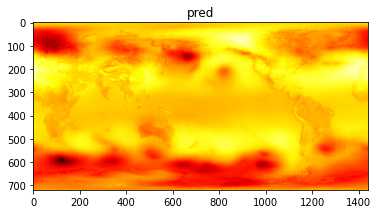

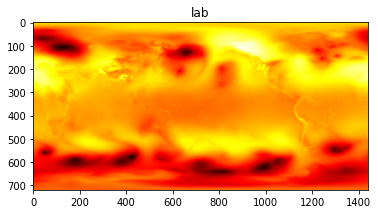

tensor([[[[ 0.9427, -0.6311, -2.4948,  ..., -0.6374, -2.3048, -1.8720],
          [ 2.4217,  3.8913,  0.4600,  ...,  3.9815,  0.9303, -0.8026],
          [ 0.5308, -0.5626,  1.9575,  ..., -0.1763,  1.7803,  0.9946],
          ...,
          [ 0.3712,  0.8010, -0.6742,  ...,  0.9260, -0.4359, -0.3600],
          [ 1.0284,  0.5615,  0.6505,  ...,  0.7517,  0.6014, -0.0319],
          [ 0.1449,  0.1426,  0.9616,  ..., -0.0102,  0.7363, -1.1544]]]],
       grad_fn=<AddBackward0>)
2t loss: 9.713056897453498e-06
10u loss: 1.9707381397893187e-06
10v loss: 1.6567800003031152e-06
msl loss: 0.0007994635379873216
fire loss: 1.8987953808391467e-05
lst loss: 0.018333330750465393
t loss: 2.456831111885549e-07
u loss: 2.6585345835883345e-07
v loss: 2.2296717361314222e-07
q loss: 2.2801818620092965e-14
z loss: 8.624525071354583e-05
Loss: 0.0010
2t pred min=217.08990478515625, max=317.47607421875
2t lab min=219.67823791503906, max=313.38189697265625
10u pred min=-25.039958953857422, max=25.617773056030

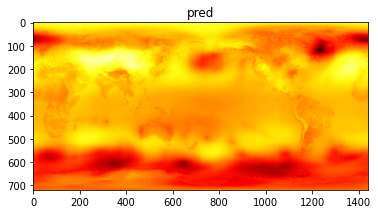

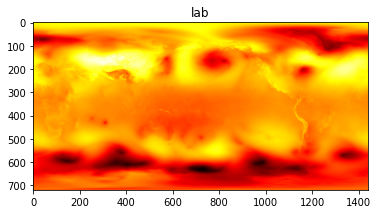

tensor([[[[-0.2233, -0.9089, -2.2916,  ..., -0.8894, -2.2384, -2.7203],
          [ 2.3562,  2.8992,  1.1210,  ...,  2.8496,  1.5848, -1.2200],
          [ 0.8237, -0.0201,  1.1812,  ...,  0.2323,  1.1554,  0.8713],
          ...,
          [ 0.5944,  1.0087, -0.6723,  ...,  1.1559, -0.3682, -0.4174],
          [ 1.0986,  0.7389,  0.6711,  ...,  0.8551,  0.6229, -0.1348],
          [-0.0093, -0.0647,  1.0155,  ..., -0.2508,  0.8789, -1.1304]]]],
       grad_fn=<AddBackward0>)
2t loss: 7.547050245193532e-06
10u loss: 1.976268322323449e-06
10v loss: 1.520919795439113e-06
msl loss: 0.0007253832882270217
fire loss: 1.8472213923814707e-05
lst loss: 0.016597241163253784
t loss: 3.773918422211864e-07
u loss: 2.7865331730936305e-07
v loss: 2.128107183807515e-07
q loss: 2.2978120057734475e-14
z loss: 9.00704981177114e-05
Loss: 0.0009
2t pred min=222.57330322265625, max=318.1802978515625
2t lab min=221.88247680664062, max=312.5915832519531
10u pred min=-20.501968383789062, max=30.118896484375
10

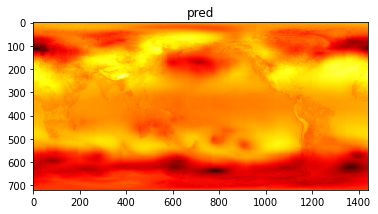

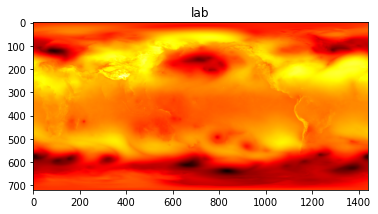

tensor([[[[ 0.0824, -1.1446, -2.4701,  ..., -0.9698, -2.6976, -2.5489],
          [ 2.0964,  2.5794,  0.7175,  ...,  2.5787,  1.1390, -1.5272],
          [ 1.0583, -0.4948,  1.5408,  ..., -0.0438,  1.3953,  0.7828],
          ...,
          [ 0.4152,  0.7816, -0.6704,  ...,  0.9255, -0.4870,  0.0291],
          [ 0.7640,  0.4521,  0.9523,  ...,  0.6089,  0.9054,  0.0323],
          [ 0.2237,  0.5188,  0.6450,  ...,  0.2574,  0.4789, -1.3639]]]],
       grad_fn=<AddBackward0>)
2t loss: 7.225811714306474e-06
10u loss: 2.005103624469484e-06
10v loss: 1.604031467650202e-06
msl loss: 0.0007185827707871795
fire loss: 1.8249462300445884e-05
lst loss: 0.014563255943357944
t loss: 2.912697141255194e-07
u loss: 2.9755125297015184e-07
v loss: 2.3015954297989083e-07
q loss: 2.4272689638934163e-14
z loss: 8.188870560843498e-05
Loss: 0.0008
2t pred min=217.92391967773438, max=315.2589416503906
2t lab min=216.5613555908203, max=318.4778137207031
10u pred min=-20.11139678955078, max=24.480854034423828

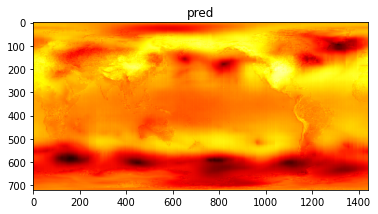

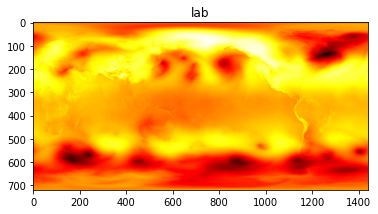

tensor([[[[-0.2572, -1.9660, -2.7831,  ..., -1.8527, -2.9458, -2.7685],
          [ 2.8832,  2.1664,  1.2557,  ...,  2.3959,  1.6452, -2.6043],
          [ 1.1768,  0.1990,  1.8626,  ...,  0.2737,  1.5643, -0.0203],
          ...,
          [-0.0903,  0.2084,  0.0862,  ...,  0.4225,  0.4599, -0.1835],
          [-0.7390,  0.8920,  2.6434,  ...,  1.2719,  2.0737, -0.6177],
          [-0.9213, -1.0390,  2.3540,  ..., -0.6127,  1.4984, -0.5623]]]],
       grad_fn=<AddBackward0>)
2t loss: 8.038447049329989e-06
10u loss: 2.1000619199185167e-06
10v loss: 1.7702211607684148e-06
msl loss: 0.0008126660832203925
fire loss: 1.84468681254657e-05
lst loss: 0.012408215552568436
t loss: 2.6828601562556287e-07
u loss: 2.9280931812536437e-07
v loss: 2.335166584543913e-07
q loss: 2.517105108872618e-14
z loss: 8.374695607926697e-05
Loss: 0.0007
2t pred min=222.90109252929688, max=316.58087158203125
2t lab min=226.39883422851562, max=320.1160583496094
10u pred min=-25.726593017578125, max=22.6679992675781

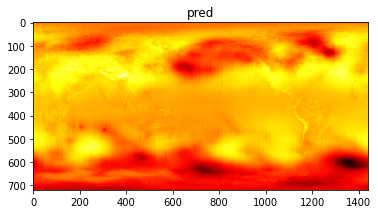

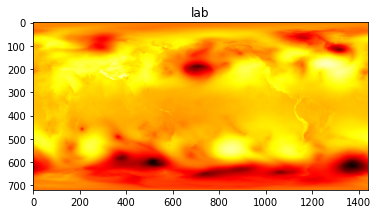

tensor([[[[ 1.4475e-03, -1.5290e+00, -3.2268e+00,  ..., -1.1813e+00,
           -3.1055e+00, -3.9663e+00],
          [ 2.6398e+00,  2.5401e+00,  1.8902e+00,  ...,  2.5939e+00,
            2.8014e+00, -3.1432e+00],
          [ 1.2743e+00,  3.7903e-01,  1.3850e+00,  ...,  3.4437e-01,
            1.3573e+00, -8.3078e-01],
          ...,
          [ 1.6506e+00,  1.3661e+00, -3.3138e-01,  ...,  1.9461e+00,
            3.1010e-01, -1.1299e+00],
          [ 7.5506e-01,  1.7476e+00, -2.0095e-01,  ...,  2.3398e+00,
           -1.0478e+00,  6.1065e-01],
          [-4.5798e-01,  1.6853e-01, -2.4771e-01,  ..., -5.3703e-01,
           -3.5548e-01,  1.6683e-01]]]], grad_fn=<AddBackward0>)
2t loss: 9.264223081117962e-06
10u loss: 1.7150621260952903e-06
10v loss: 1.4203494629327906e-06
msl loss: 0.0005681657930836082
fire loss: 1.8358077795710415e-05
lst loss: 0.011086076498031616
t loss: 2.2204424965366343e-07
u loss: 2.6382139139968785e-07
v loss: 1.8952424341023288e-07
q loss: 2.443477955778664e-14

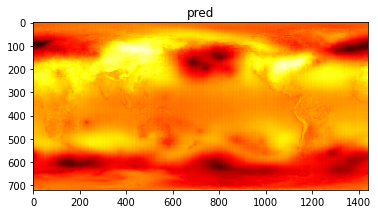

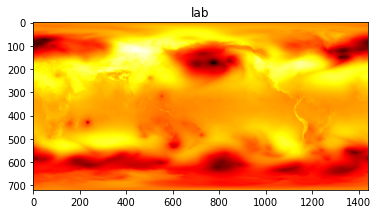

tensor([[[[ 0.4965, -1.1148, -3.6875,  ..., -1.0943, -3.7151, -3.9475],
          [ 2.4017,  2.5658,  1.2929,  ...,  2.6123,  1.8647, -2.5825],
          [ 1.7631,  0.2151,  1.5273,  ...,  0.3016,  1.1917, -0.5507],
          ...,
          [ 1.0340,  1.6600,  0.0985,  ...,  1.7827,  0.3318, -1.5192],
          [ 0.5763,  1.5840, -0.5862,  ...,  1.8342, -0.6056,  0.3764],
          [ 0.7340, -0.0771,  0.0198,  ..., -0.1978, -0.4048,  0.7907]]]],
       grad_fn=<AddBackward0>)
2t loss: 7.279782494151732e-06
10u loss: 1.7891172774398e-06
10v loss: 1.5282828371709911e-06
msl loss: 0.0005980251589789987
fire loss: 1.731514566927217e-05
lst loss: 0.009233763441443443
t loss: 2.2113684394753363e-07
u loss: 2.705914710077195e-07
v loss: 2.1116665038789506e-07
q loss: 2.3850640226371657e-14
z loss: 7.177321094786748e-05
Loss: 0.0005
2t pred min=223.69720458984375, max=319.7762145996094
2t lab min=226.6628875732422, max=318.5080261230469
10u pred min=-16.39190101623535, max=18.340885162353516
1

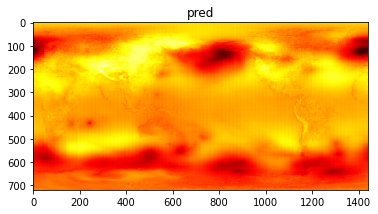

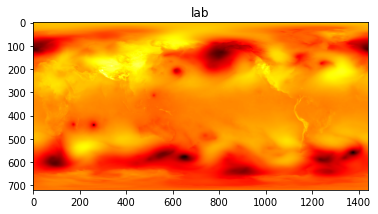

tensor([[[[-0.4961, -1.4962, -3.6992,  ..., -1.4838, -4.2952, -3.3199],
          [ 1.7194,  2.6472,  1.5405,  ...,  2.6829,  2.2462, -3.0290],
          [ 1.9761,  0.3802,  1.3914,  ...,  0.1774,  1.2411, -1.3226],
          ...,
          [ 0.5048,  0.8803, -0.5463,  ...,  1.4186, -0.0165, -1.0728],
          [ 1.0828,  0.3803,  0.8891,  ...,  1.8750, -0.4151, -0.1487],
          [-0.0133,  0.0951,  0.6556,  ...,  0.2033, -0.5198, -0.2126]]]],
       grad_fn=<AddBackward0>)
2t loss: 6.596692855964648e-06
10u loss: 1.5861014617257752e-06
10v loss: 1.383049834657868e-06
msl loss: 0.0004963979008607566
fire loss: 1.6428697563242167e-05
lst loss: 0.008086616173386574
t loss: 2.0420006308086158e-07
u loss: 2.647707049163728e-07
v loss: 1.920270022992554e-07
q loss: 2.363598005468079e-14
z loss: 5.949364640400745e-05
Loss: 0.0005
2t pred min=226.3444366455078, max=318.2187194824219
2t lab min=228.81222534179688, max=316.6225280761719
10u pred min=-15.827958106994629, max=20.871191024780273

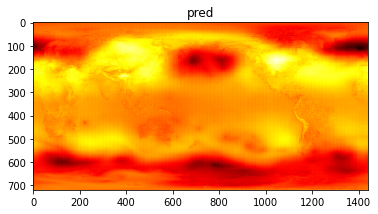

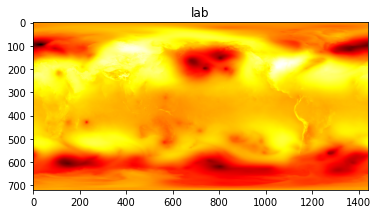

tensor([[[[ 0.3105, -1.1045, -4.2832,  ..., -1.1683, -4.3029, -3.4059],
          [ 1.5644,  2.4084,  0.6731,  ...,  2.5107,  1.4035, -2.6489],
          [ 1.9958,  0.0769,  1.1922,  ...,  0.2366,  1.1503, -0.3528],
          ...,
          [ 0.6410,  0.8663, -0.6012,  ...,  0.9423, -0.3637, -0.4152],
          [ 0.7098,  0.8342,  0.8336,  ...,  0.9278,  0.8051, -0.1654],
          [-0.0595,  0.3055,  0.6103,  ...,  0.1081,  0.4715, -1.1008]]]],
       grad_fn=<AddBackward0>)
2t loss: 7.401856237265747e-06
10u loss: 1.7347826997138327e-06
10v loss: 1.4355152870848542e-06
msl loss: 0.0006388286710716784
fire loss: 1.55363159137778e-05
lst loss: 0.007038322743028402
t loss: 2.3161437923135964e-07
u loss: 2.930699736225506e-07
v loss: 2.193606007949711e-07
q loss: 2.3719771941954973e-14
z loss: 7.39616880309768e-05
Loss: 0.0004
2t pred min=216.9698486328125, max=317.80560302734375
2t lab min=218.49359130859375, max=316.94244384765625
10u pred min=-18.54701805114746, max=18.522933959960938

In [ ]:
# training 
model.train()
model.configure_activation_checkpointing()
optimizer = optim.AdamW(model.parameters(), lr=4e-5, weight_decay=5e-6)
# scaler = torch.cuda.amp.GradScaler() #
# scaler = torch.amp.GradScaler('cuda') #

ctr = 1
num_epochs = 1

# with torch.cuda.device('cuda'):
#     torch.cuda.empty_cache()
# torch.cuda.empty_cache()
for epoch in range(num_epochs):  # Loop over epochs
    # model.train()  # Set model to training mode
    for batch in dataloader:  # Iterate over batches
        # Unpack the batch
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        # Move data to the appropriate device
        # features = {key: val.to(device) for key, val in features.items()}  # For dict-based features
        # plt.imshow(features.surf_vars['10v'][0][0, :, :].squeeze().cpu().numpy(), cmap="hot")
        # plt.title("feature")
        # plt.show()
        labels = labels.to(device)
        features = features.to(device)
        # print(features.surf_vars["lst"])
        # print(features)
        
        optimizer.zero_grad()  # Zero the gradients

        # with torch.cuda.amp.autocast():
        # with torch.amp.autocast('cuda'):
            # Forward pass
            # outputs = model(features)
        pred = model.forward(features)
        print(pred.surf_vars["fire"])
        # print(labels.surf_vars["fire"])
        # pred is already on gpu 
        # pred = pred.to(device)[
        # print(features)
        # Compute the loss
        loss = loss_func(labels,pred)
        print(f"Loss: {loss.item():.4f}")

        # print("msl pred min/max:", pred.surf_vars["msl"].min().detach().cpu().item(), pred.surf_vars["msl"].max().detach().cpu().item())
        # print("msl target min/max:", labels.surf_vars["msl"].min().detach().cpu().item(), labels.surf_vars["msl"].max().detach().cpu().item())
        # print("lst pred min/max:", pred.surf_vars["lst"].min().detach().cpu().item(), pred.surf_vars["lst"].max().detach().cpu().item())
        # print("lst target min/max:", labels.surf_vars["lst"].min().detach().cpu().item(), labels.surf_vars["lst"].max().detach().cpu().item())
        # print("z pred min/max:", pred.atmos_vars["z"].min().detach().cpu().item(), pred.atmos_vars["z"].max().detach().cpu().item())
        # print("z target min/max:", labels.atmos_vars["z"].min().detach().cpu().item(), labels.atmos_vars["z"].max().detach().cpu().item())

        # print("msl pred min/max:", pred.surf_vars["msl"].min(), pred.surf_vars["msl"].max())
        # print("msl target min/max:", labels.surf_vars["msl"].min(), labels.surf_vars["msl"].max())
        # print("lst pred min/max:", pred.surf_vars["lst"].min(), pred.surf_vars["lst"].max())
        # print("lst target min/max:", labels.surf_vars["lst"].min(), labels.surf_vars["lst"].max())
        # print("z pred min/max:", pred.atmos_vars["z"].min(), pred.atmos_vars["z"].max())
        # print("z target min/max:", labels.atmos_vars["z"].min(), labels.atmos_vars["z"].max())

        for key in pred.surf_vars.keys():
            print(f"{key} pred min={pred.surf_vars[key].min().item()}, max={pred.surf_vars[key].max().item()}")
            print(f"{key} lab min={labels.surf_vars[key].min().item()}, max={labels.surf_vars[key].max().item()}")


        
        # Backward pass and optimization
        loss.backward()  # Backpropagate  nan occurs here 
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5) ######## importnat line 

        # gradient flow testing
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         grad_norm = param.grad.norm().item()
        #         print(f"{name} grad norm: {grad_norm}")
        #     else:
        #         print(f"{name} has no gradients")

        for name, param in model.named_parameters():
            if "weight" in name:
                param.data = torch.clamp(param.data, min=-1e8, max=1e8)


        # optimizer.step()  # Update the weights
        optimizer.step()
        # scaler.update()
        # torch.cuda.empty_cache()
        print(f"computed batch {ctr}")
        ctr += 1
        plt.imshow(pred.surf_vars['msl'].squeeze().detach().cpu().numpy(), cmap="hot")
        plt.title("pred")
        plt.show()
        
        plt.imshow(labels.surf_vars['msl'].squeeze().detach().cpu().numpy(), cmap="hot")
        plt.title("lab")
        plt.show()
        
        # Debug memory usage
        # print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        # print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
        with torch.cuda.device('cuda'):
            torch.cuda.empty_cache()
        # print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        # print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


        
        assert not torch.isnan(pred.surf_vars["msl"]).any(), "NaN in msl predictions!"
        assert not torch.isnan(labels.surf_vars["msl"]).any(), "NaN in msl targets!"
        # assert not torch.isinf(pred.surf_vars["msl"]).any(), "Inf in msl predictions!"
        assert not torch.isinf(labels.surf_vars["msl"]).any(), "Inf in msl targets!"
        
        assert not torch.isnan(pred.surf_vars["lst"]).any(), "NaN in lst predictions!"
        assert not torch.isnan(labels.surf_vars["lst"]).any(), "NaN in lst targets!"
        # assert not torch.isinf(pred.surf_vars["lst"]).any(), "Inf in msl predictions!"
        assert not torch.isinf(labels.surf_vars["lst"]).any(), "Inf in lst targets!"
        
        assert not torch.isnan(pred.atmos_vars["z"]).any(), "NaN in z predictions!"
        assert not torch.isnan(labels.atmos_vars["z"]).any(), "NaN in z targets!"
        # assert not torch.isinf(pred.atmos_vars["z"]).any(), "Inf in msl predictions!"
        assert not torch.isinf(labels.atmos_vars["z"]).any(), "Inf in z targets!"

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    

In [12]:
# training 
model.train()
model.configure_activation_checkpointing()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-6)
# scaler = torch.cuda.amp.GradScaler() #
scaler = torch.amp.GradScaler('cuda') #

ctr = 1
num_epochs = 1

# with torch.cuda.device('cuda'):
#     torch.cuda.empty_cache()
# torch.cuda.empty_cache()
for epoch in range(num_epochs):  # Loop over epochs
    # model.train()  # Set model to training mode
    for batch in dataloader:  # Iterate over batches
        # Unpack the batch
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        # Move data to the appropriate device
        # features = {key: val.to(device) for key, val in features.items()}  # For dict-based features
        # plt.imshow(features.surf_vars['10v'][0][0, :, :].squeeze().cpu().numpy(), cmap="hot")
        # plt.title("feature")
        # plt.show()
        labels = labels.to(device)
        features = features.to(device)
        # print(features.surf_vars["lst"])
        # print(features)
        
        optimizer.zero_grad()  # Zero the gradients

        # with torch.cuda.amp.autocast():
        with torch.amp.autocast('cuda'):
            # Forward pass
            # outputs = model(features)
            pred = model.forward(features)
            print(pred.surf_vars["fire"])
            # print(labels.surf_vars["fire"])
            # pred is already on gpu 
            # pred = pred.to(device)[
            # print(features)
            # Compute the loss
            loss = loss_func(labels,pred)
            print(f"Loss: {loss.item():.4f}")

            print("msl pred min/max:", pred.surf_vars["msl"].min().detach().cpu().item(), pred.surf_vars["msl"].max().detach().cpu().item())
            print("msl target min/max:", labels.surf_vars["msl"].min().detach().cpu().item(), labels.surf_vars["msl"].max().detach().cpu().item())
            print("lst pred min/max:", pred.surf_vars["lst"].min().detach().cpu().item(), pred.surf_vars["lst"].max().detach().cpu().item())
            print("lst target min/max:", labels.surf_vars["lst"].min().detach().cpu().item(), labels.surf_vars["lst"].max().detach().cpu().item())
            print("z pred min/max:", pred.atmos_vars["z"].min().detach().cpu().item(), pred.atmos_vars["z"].max().detach().cpu().item())
            print("z target min/max:", labels.atmos_vars["z"].min().detach().cpu().item(), labels.atmos_vars["z"].max().detach().cpu().item())

            assert not torch.isnan(pred.surf_vars["msl"]).any(), "NaN in msl predictions!"
            assert not torch.isnan(labels.surf_vars["msl"]).any(), "NaN in msl targets!"
            # assert not torch.isinf(pred.surf_vars["msl"]).any(), "Inf in msl predictions!"
            assert not torch.isinf(labels.surf_vars["msl"]).any(), "Inf in msl targets!"
            
            assert not torch.isnan(pred.surf_vars["lst"]).any(), "NaN in lst predictions!"
            assert not torch.isnan(labels.surf_vars["lst"]).any(), "NaN in lst targets!"
            # assert not torch.isinf(pred.surf_vars["lst"]).any(), "Inf in msl predictions!"
            assert not torch.isinf(labels.surf_vars["lst"]).any(), "Inf in lst targets!"
            
            assert not torch.isnan(pred.atmos_vars["z"]).any(), "NaN in z predictions!"
            assert not torch.isnan(labels.atmos_vars["z"]).any(), "NaN in z targets!"
            # assert not torch.isinf(pred.atmos_vars["z"]).any(), "Inf in msl predictions!"
            assert not torch.isinf(labels.atmos_vars["z"]).any(), "Inf in z targets!"


        
        # Backward pass and optimization
        scaler.scale(loss).backward()  # Backpropagate  nan occurs here 
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! gradient clipping!
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"{name}: grad_norm1={torch.norm(param.grad).item()}")
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"{name}: grad_norm={torch.norm(param.grad).item()}")

        # optimizer.step()  # Update the weights
        scaler.step(optimizer)
        scaler.update()
        # torch.cuda.empty_cache()
        print(f"computed batch {ctr}")
        ctr += 1
        plt.imshow(pred.surf_vars['2t'].squeeze().detach().cpu().numpy(), cmap="hot")
        plt.title("pred")
        plt.show()
        
        plt.imshow(labels.surf_vars['2t'].squeeze().detach().cpu().numpy(), cmap="hot")
        plt.title("lab")
        plt.show()
        
        # Debug memory usage
        # print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        # print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
        with torch.cuda.device('cuda'):
            torch.cuda.empty_cache()
        # print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        # print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    

tensor([[[[-0.8540,  1.4551,  1.2852,  ...,  1.2881,  1.0293,  1.0479],
          [-1.5264,  0.7134,  1.3799,  ...,  0.8169,  1.4766, -0.5796],
          [-1.2822,  1.7881, -2.1094,  ...,  1.8516, -2.1699,  1.1748],
          ...,
          [-0.0126, -2.2891,  0.0323,  ..., -2.3340,  0.0402,  0.8281],
          [ 0.1815, -0.8433, -0.8125,  ..., -0.5684, -0.8691, -1.4463],
          [-0.4226,  1.1016,  0.1462,  ...,  1.4668,  0.1884,  1.3164]]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
2t loss: 1.1804767382272985e-05
10u loss: 2.2158853880682727e-06
10v loss: 2.23247161557083e-06
msl loss: inf
fire loss: 2.941444336101995e-06
lst loss: 0.035366225987672806
t loss: 3.0278110330073105e-07
u loss: 3.1408350764650095e-07
v loss: 2.535688281568582e-07
q loss: 2.6339300532307597e-11
z loss: inf
Loss: inf
msl pred min/max: inf inf
msl target min/max: 94802.6328125 103676.953125
lst pred min/max: -31808.0 56864.0
lst target min/max: -32768.0 17037.42578125
z pred mi

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [13]:
## freeing memory after restarting model

with torch.no_grad():
    torch.cuda.empty_cache()

import gc
torch.cuda.empty_cache()
gc.collect()

521

In [14]:
torch.save(model.state_dict(), "weights_loss.pth")

### see aws id for missing line
# bucket_name = 'globfire-gooddata'
# s3.upload_file("aurora_fire_weights.pth", bucket_name, "aurora_fire_weights.pth")

### some debug stuff (not important for runing)

In [ ]:
# model training 

model.train()
model.configure_activation_checkpointing()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-6)

model = model.to(device)
model.train()
model.configure_activation_checkpointing()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

num_epochs = 1
torch.cuda.empty_cache()
for epoch in range(num_epochs):  # Loop over epochs
    # model.train()  # Set model to training mode
    for batch in dataloader:  # Iterate over batches
        # Unpack the batch
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        # Move data to the appropriate device
        # features = {key: val.to(device) for key, val in features.items()}  # For dict-based features
        labels = labels.to(device)
        # features = features.to(device)

        # Forward pass
        # outputs = model(features)
        pred = model.forward(features)
        # pred is already on gpu 
        # pred = pred.to(device)[
        print(pred)
        # Compute the loss
        loss = loss_func(labels,pred)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate
        optimizer.step()  # Update the weights
        torch.cuda.empty_cache()
        print("computed first batch")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    break

In [15]:
# model training 

import torch
import torch.nn as nn
import torch.optim as optim

model.train()
model.configure_activation_checkpointing()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-6)

model = model.to(device)
model.train()
model.configure_activation_checkpointing()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

num_epochs = 1
torch.cuda.empty_cache()
for epoch in range(num_epochs):  # Loop over epochs
    # model.train()  # Set model to training mode
    for batch in dataloader:  # Iterate over batches
        # Unpack the batch
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        # Move data to the appropriate device
        # features = {key: val.to(device) for key, val in features.items()}  # For dict-based features
        labels = labels.to(device)
        # features = features.to(device)

        # Forward pass
        # outputs = model(features)
        pred = model.forward(features)
        # pred is already on gpu 
        # pred = pred.to(device)
        print(pred)
        # Compute the loss
        loss = loss_func(labels,pred)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate
        optimizer.step()  # Update the weights
        torch.cuda.empty_cache()
        print("computed first batch")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    break

Batch(surf_vars={'2t': tensor([[[[248.2111, 250.3261, 250.2283,  ..., 249.8091, 250.0388, 247.3506],
          [256.5222, 255.5726, 255.3369,  ..., 255.0719, 255.2536, 245.8392],
          [252.1862, 253.3263, 249.0282,  ..., 253.4009, 249.3633, 248.7849],
          ...,
          [243.7909, 243.7615, 243.8710,  ..., 243.7093, 243.9118, 244.1356],
          [244.0923, 243.9736, 244.1088,  ..., 243.8568, 243.9820, 244.0134],
          [243.9003, 243.9125, 243.7339,  ..., 243.9700, 243.8595, 243.8047]]]],
       device='cuda:0', grad_fn=<AddBackward0>), '10u': tensor([[[[  3.5809,   3.3212,   1.3584,  ...,   3.0293,   1.0162,   3.7811],
          [ -7.9823,  -7.5491,  -9.8704,  ...,  -7.3736,  -9.8940,  -7.1199],
          [ -4.5390,  -4.3756, -10.2827,  ...,  -4.1192, -10.1291,  -8.2069],
          ...,
          [ -3.3834,  -3.3105,  -3.2968,  ...,  -3.2817,  -3.2331,  -3.3291],
          [ -3.0977,  -3.0532,  -3.0555,  ...,  -3.1011,  -3.0014,  -3.0439],
          [ -2.4023,  -2.4306,

/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed first batch
Batch(surf_vars={'2t': tensor([[[[246.5566, 249.0670, 248.9123,  ..., 248.7042, 248.8638, 246.1772],
          [254.5370, 254.2614, 253.9191,  ..., 253.9032, 253.9358, 248.8828],
          [250.2312, 251.7356, 247.2331,  ..., 251.6860, 247.5735, 246.9567],
          ...,
          [245.6753, 245.1755, 245.6828,  ..., 246.0768, 246.3116, 246.4983],
          [247.3932, 246.8410, 247.1264,  ..., 246.4315, 246.4003, 246.4061],
          [245.2274, 245.0392, 245.4596,  ..., 246.7330, 246.5004, 246.3099]]]],
       device='cuda:0', grad_fn=<AddBackward0>), '10u': tensor([[[[  2.6317,   2.3470,   0.6036,  ...,   1.8345,   0.3006,   2.6186],
          [ -8.5061,  -7.9438, -10.3034,  ...,  -7.3911,  -9.7658,  -7.0160],
          [ -5.3238,  -5.0784, -10.9660,  ...,  -4.7888, -10.6551,  -8.6438],
          ...,
          [ -4.4275,  -4.4794,  -4.4256,  ...,  -3.8151,  -3.9774,  -4.1757],
          [ -3.8242,  -3.6514,  -3.3166,  ...,  -4.1819,  -4.0720,  -4.0007],
         

/home/ubuntu/.local/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


computed first batch
Epoch [1/1], Loss: 0.0017


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
# !export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:64 3.17 112

In [ ]:
print(os.getenv("PYTORCH_CUDA_ALLOC_CONF"))

In [ ]:
print(torch.cuda.memory_summary())

### predicting on new data

In [8]:
model = Aurora(
    use_lora=False,
    autocast=True,      # reduces memory usage
    surf_vars=("2t", "10u", "10v", "msl", "fire","lst"),
    static_vars=("lsm", "z", "slt"),
    atmos_vars=("z", "u", "v", "t", "q"),
)
# model = Aurora(
#     use_lora=False,
#     autocast=True,      # reduces memory usage
#     # surf_vars=("2t", "10u", "10v", "msl"),
#     surf_vars=("2t", "10u", "10v", "msl", "fire"),
#     static_vars=("lsm", "z", "slt"),
#     atmos_vars=("z", "u", "v", "t", "q"),
# )

# model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
model.load_state_dict(torch.load("aurora_fire_weights_all.pth"), strict=False)
model = model.to("cuda")

/tmp/ipykernel_2457/1207869413.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("aurora_fire_weights_all.pth"), strict=False)


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

accuracy = 0
precision = 0
recall = 0
f1 = 0
iou = 0
total_samples = 0

threshold = 0.5 



model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computations
    # for batch in dataloader_test:
    for batch in dataloader_test:
        
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        

        # print("label unique:", np.unique(labels.surf_vars["fire"].cpu().numpy())[:10])
        # print("feature unique:",np.unique(features.surf_vars["fire"].cpu().numpy()))

        labels = labels.to(device)
        features = features.to(device)
        
        pred = model.forward(features)
        # pred = pred.to(device)
        # print(pred.surf_vars["fire"].shape)
        # print(labels.surf_vars["fire"].shape)

        # flatten turns 720, 1440 into 1036800 
        pred_fire = pred.surf_vars["fire"].cpu().numpy().flatten() 
        pred_fire = np.nan_to_num(pred_fire, nan=0)
        pred_fire = (pred_fire > 0).astype(int)    # equivalent to doing sigmoid with threshold of 0.5
        lab_fire = labels.surf_vars["fire"].cpu().numpy().flatten() 
        # lab_fire = (lab_fire > threshold).astype(int)  # this just converts float to int
        lab_fire = (lab_fire).astype(int)  # this just converts float to int
        
        # print("lab_fire:", lab_fire.shape, lab_fire.dtype, lab_fire)
        # print("pred_fire:", pred_fire.shape, pred_fire.dtype, pred_fire)
        # print(len(np.unique(lab_fire)))
        # print((np.unique(lab_fire)))
        # print(len(np.unique(pred_fire)))
        # print((np.unique(pred_fire)))

        # Assume `preds` and `labels` are your predicted and true grids (flattened for metrics)
        # pred_fire = pred_fire.cpu().numpy().flatten()
        # lab_fire = lab_fire.cpu().numpy().flatten()
        # pred_fire = pred_fire.numpy().flatten()
        # lab_fire = lab_fire.numpy().flatten()

        # Compute metrics
        accuracy += accuracy_score(lab_fire, pred_fire)
        precision += precision_score(lab_fire, pred_fire, zero_division=1)
        recall += recall_score(lab_fire, pred_fire, zero_division=1)
        f1 += f1_score(lab_fire, pred_fire, zero_division=1)
        iou += jaccard_score(lab_fire, pred_fire)
        # total_samples += labels.size(0)
        total_samples += 1

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")

Accuracy: 46.1522
Precision: 0.5445
Recall: 39.2499
F1 Score: 1.0727
IoU: 0.5408


same code but with visalizaztions

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

accuracy = 0
precision = 0
recall = 0
f1 = 0
iou = 0
total_samples = 0

threshold = 0.5 

# Initialize an array to hold the sum of predicted fires for visualization
pred_grid = np.zeros((720, 1440))
lab_grid = np.zeros((720, 1440))

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computations
    # for batch in dataloader_test:
    for batch in dataloader_test:        
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        
        labels = labels.to(device)
        features = features.to(device)
        
        pred = model.forward(features)
        
        # flatten turns 720, 1440 into 1036800 
        pred_fire = pred.surf_vars["fire"].cpu().numpy().reshape(720, 1440)
        pred_fire = np.nan_to_num(pred_fire, nan=0)
        lab_fire = labels.surf_vars["fire"].cpu().numpy().reshape(720, 1440)

        # adding to grid
        pred_grid += pred_fire
        lab_grid += lab_fire

        # flattening fr fr
        pred_fire = pred_fire.flatten()
        lab_fire = lab_fire.flatten()

        
        pred_fire = (pred_fire > threshold).astype(int)
        lab_fire = (lab_fire > threshold).astype(int)

        # Compute metrics
        accuracy += accuracy_score(lab_fire, pred_fire)
        precision += precision_score(lab_fire, pred_fire, zero_division=1)
        recall += recall_score(lab_fire, pred_fire, zero_division=1)
        f1 += f1_score(lab_fire, pred_fire, zero_division=1)
        iou += jaccard_score(lab_fire, pred_fire)
        # total_samples += labels.size(0)
        total_samples += 1

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")

in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem feature: [0. 1.]
in getitem label: [0 1]
in getitem f

In [23]:
print(pred_grid)
print(lab_grid)

pred_grid_flat = (pred_grid > threshold).astype(int)
print(pred_grid_flat)

[[ 0.  1.  0. ...  2.  0. 68.]
 [ 0.  0.  5. ...  0.  6. 40.]
 [ 2. 31.  0. ... 37.  0. 73.]
 ...
 [ 1.  8.  3. ... 15.  3. 18.]
 [60.  1.  0. ...  3.  0. 59.]
 [41. 70.  1. ... 71.  3. 49.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0 1 0 ... 1 0 1]
 [0 0 1 ... 0 1 1]
 [1 1 0 ... 1 0 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 0 ... 1 0 1]
 [1 1 1 ... 1 1 1]]


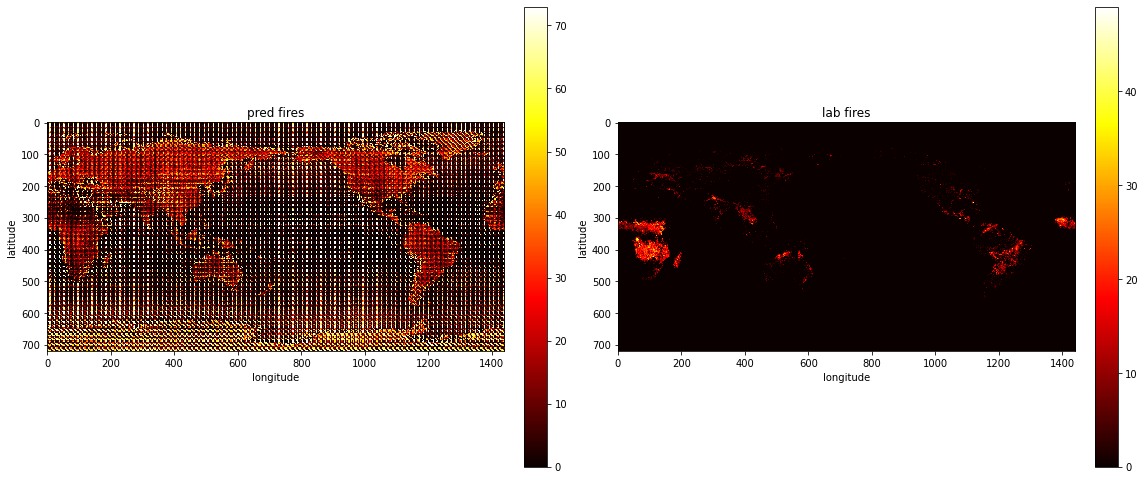

In [27]:

#plotting
fig, axes  = plt.subplots(1, 2, figsize = (16,8))
axes[0].imshow(pred_grid, cmap = 'hot', interpolation = 'nearest')
axes[0].set_title('pred fires')
axes[0].set_xlabel('longitude')
axes[0].set_ylabel('latitude')
axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(lab_grid, cmap = 'hot', interpolation = 'nearest')
axes[1].set_title('lab fires')
axes[1].set_xlabel('longitude')
axes[1].set_ylabel('latitude')
axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)


# plt.colorbar(label='Number of predictions')
plt.tight_layout()
plt.show()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
total samples 1
total samples 2
total samples 3
total samples 4
total samples 5
total samples 6
total samples 7
total samples 8
total samples 9
total samples 10
total samples 11
total samples 12
total samples 13
total samples 14
total samples 15
total samples 16
total samples 17
total samples 18
total samples 19
total samples 20
total samples 21
total samples 22
total samples 23
total samples 24
total samples 25
total samples 26
total samples 27
total samples 28
total samples 29
total samples 30
total samples 31
total samples 32
total samples 33
total samples 34
total samples 35
total samples 36
total samples 37
total samples 38
total samples 39
total samples 40
total samples 41
total samples 42
total samples 43
total samples 44
total samples 45
total samples 46
total samples 47
total samples 48
total samples 49
total samples 50
total

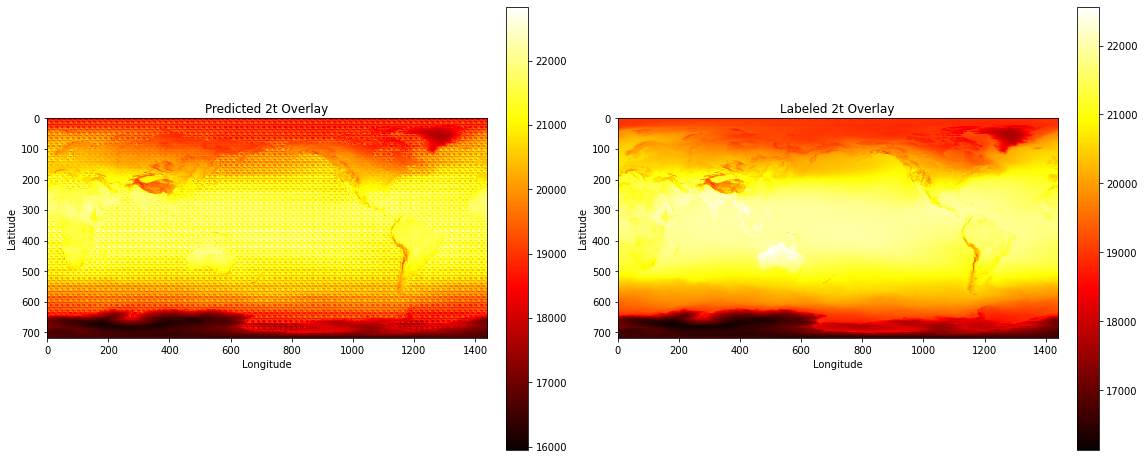

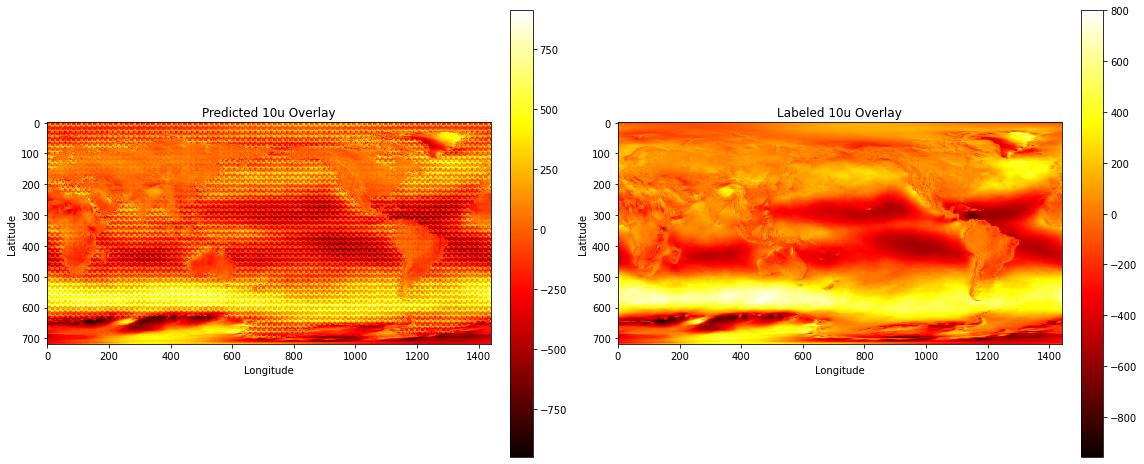

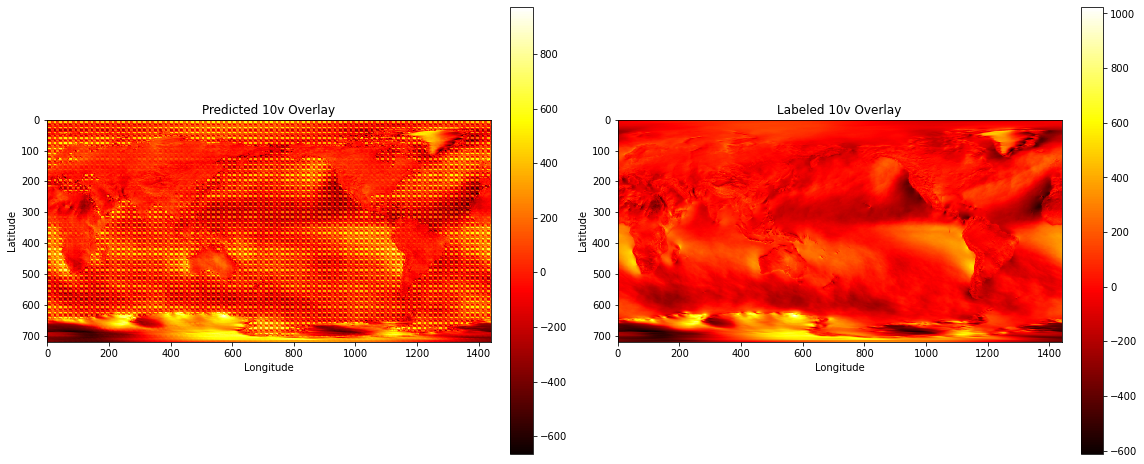

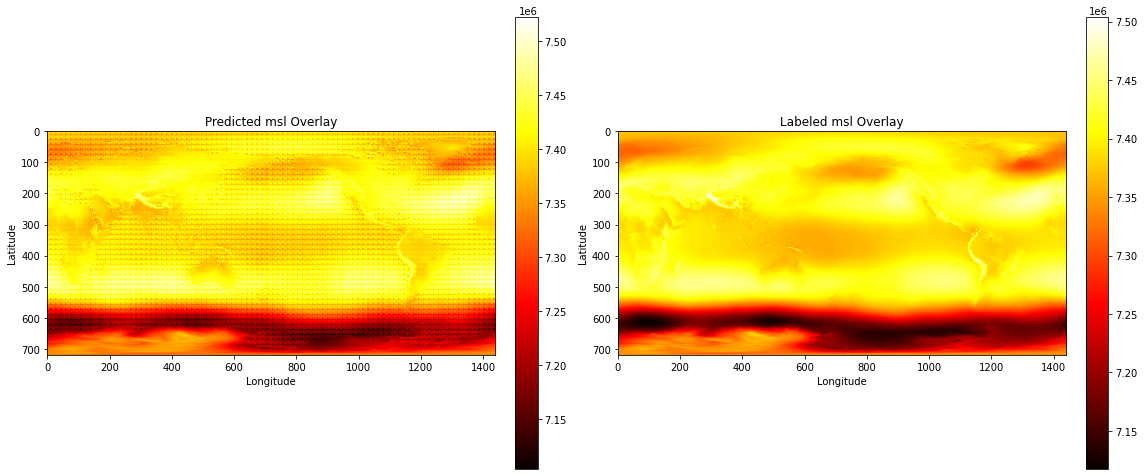

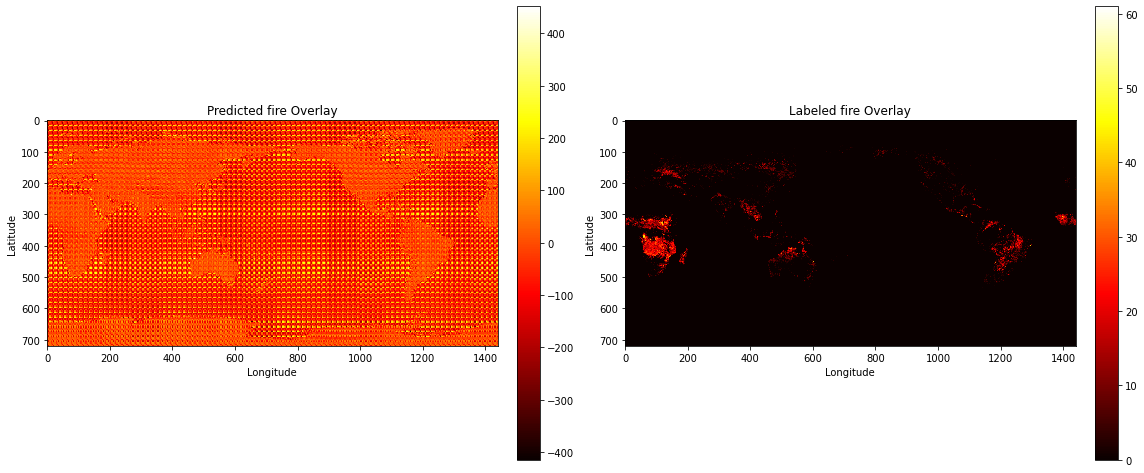

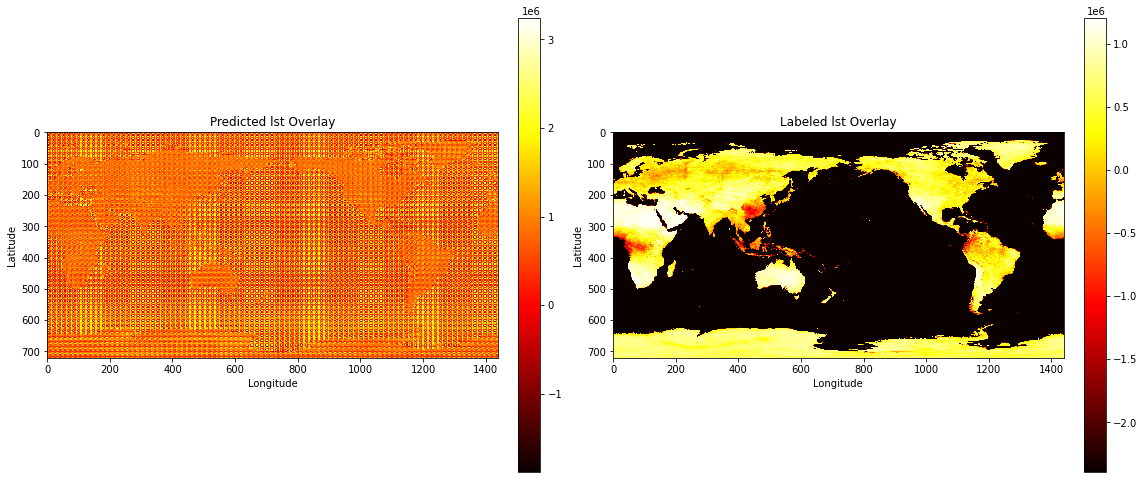

In [9]:
##### import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

accuracy = {}
precision = {}
recall = {}
f1 = {}
iou = {}
total_samples = 0

threshold = 0.5 

# Initialize dictionaries to hold cumulative grids for each variable
pred_grids = {}
pred_grids_thresh = {}
lab_grids = {}

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computations
    for batch in dataloader_test:        
        features, labels = batch  # Ensure your Dataset and collate function return the right format
        
        labels = labels.to(device)
        features = features.to(device)
        
        pred = model.forward(features)
        
        # Iterate through all variables in surf_vars
        for var in pred.surf_vars.keys():
            # Initialize grids for each variable if not already done
            if var not in pred_grids:
                pred_grids[var] = np.zeros((720, 1440))
                lab_grids[var] = np.zeros((720, 1440))
                accuracy[var] = 0
                precision[var] = 0
                recall[var] = 0
                f1[var] = 0
                iou[var] = 0

            # Reshape and threshold predictions and labels for the current variable
            pred_var = pred.surf_vars[var].cpu().numpy().reshape(720, 1440)
            pred_var = np.nan_to_num(pred_var, nan=0)
            
            lab_var = labels.surf_vars[var].cpu().numpy().reshape(720, 1440)

            # Accumulate for visualization
            pred_grids[var] += torch.sigmoid(pred_var)
            lab_grids[var] += lab_var

            if var == 'fire':
                pred_grids_thresh[var] += (pred_grids[var] > threshold).astype(int)

            # # Flatten for metrics calculation
            # pred_var_flat = pred_var.flatten()
            # lab_var_flat = lab_var.flatten()
            pred_var = pred_var.astype(int)
            lab_var = lab_var.astype(int)

            # # Compute metrics for the current variable
            # accuracy[var] += accuracy_score(lab_var_flat, pred_var_flat)
            # precision[var] += precision_score(lab_var_flat, pred_var_flat, zero_division=1)
            # recall[var] += recall_score(lab_var_flat, pred_var_flat, zero_division=1)
            # f1[var] += f1_score(lab_var_flat, pred_var_flat, zero_division=1)
            # iou[var] += jaccard_score(lab_var_flat, pred_var_flat)
        
        total_samples += 1
        # print("total samples", total_samples)

# # Compute average metrics for each variable
# for var in pred_grids.keys():
#     accuracy[var] /= total_samples
#     precision[var] /= total_samples
#     recall[var] /= total_samples
#     f1[var] /= total_samples
#     iou[var] /= total_samples
#     print(f"Variable: {var}")
#     print(f"  Accuracy: {accuracy[var]:.4f}")
#     print(f"  Precision: {precision[var]:.4f}")
#     print(f"  Recall: {recall[var]:.4f}")
#     print(f"  F1 Score: {f1[var]:.4f}")
#     print(f"  IoU: {iou[var]:.4f}")

# Plotting for each variable using subplots
for var in pred_grids.keys():
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot predicted grid for the current variable
    axes[0].imshow(pred_grids[var], cmap='hot', interpolation='nearest')
    axes[0].set_title(f'Predicted {var} Overlay')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

    # Plot labeled grid for the current variable
    axes[1].imshow(lab_grids[var], cmap='hot', interpolation='nearest')
    axes[1].set_title(f'Labeled {var} Overlay')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)

    # Show the plots
    plt.tight_layout()
    plt.show()

    
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# Plot predicted grid for the current variable
axes[0].imshow(pred_grids_thresh['fire'], cmap='hot', interpolation='nearest')
axes[0].set_title(f'Predicted {'fire'} Overlay')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

# Plot labeled grid for the current variable
axes[1].imshow(lab_grids[var], cmap='hot', interpolation='nearest')
axes[1].set_title(f'Labeled {var} Overlay')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)

# Show the plots
plt.tight_layout()
plt.show()

In [29]:
# Create a dictionary to hold the data arrays for each variable
data_dict = {}

for var in pred_grids.keys():
    # Create DataArrays for pred and lab grids
    pred_da = xr.DataArray(
        pred_grids[var], 
        dims=["lat", "lon"], 
        coords={"lat": np.arange(720), "lon": np.arange(1440)},
        name=f"pred_{var}"
    )
    
    lab_da = xr.DataArray(
        lab_grids[var], 
        dims=["lat", "lon"], 
        coords={"lat": np.arange(720), "lon": np.arange(1440)},
        name=f"lab_{var}"
    )
    
    # Add them to the dictionary
    data_dict[f"pred_{var}"] = pred_da
    data_dict[f"lab_{var}"] = lab_da

# Combine all DataArrays into a single Dataset
dataset = xr.Dataset(data_dict)

# Save the dataset to a NetCDF file
output_path = "preliminary_aurora_results.nc"
dataset.to_netcdf(output_path)

print(f"NetCDF file saved to {output_path}")


NetCDF file saved to preliminary_aurora_results.nc


In [ ]:
from aurora import Aurora

model = Aurora(
    use_lora=False,  # Model was not fine-tuned.
    autocast=True,  # Use AMP.
)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

batch = ...  # Load some data.

model = model.cuda()
model.train()
model.configure_activation_checkpointing()

pred = model.forward(batch)
loss = ...
loss.backward()

## trying to see if thing works with generic aah data 721 - 720 check


torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])


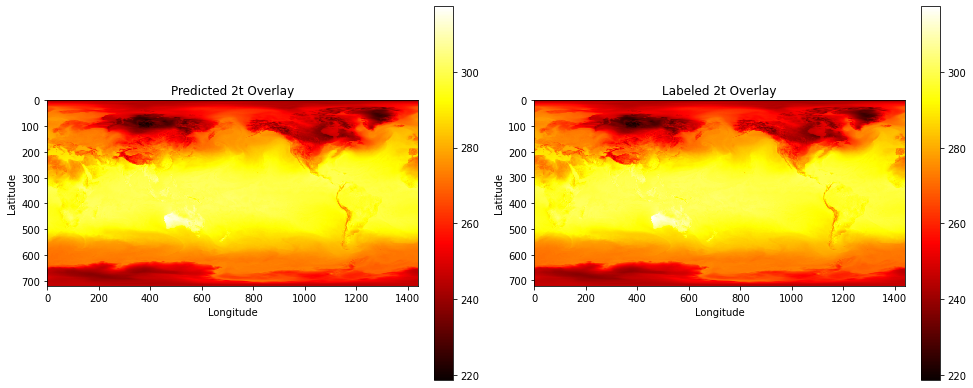

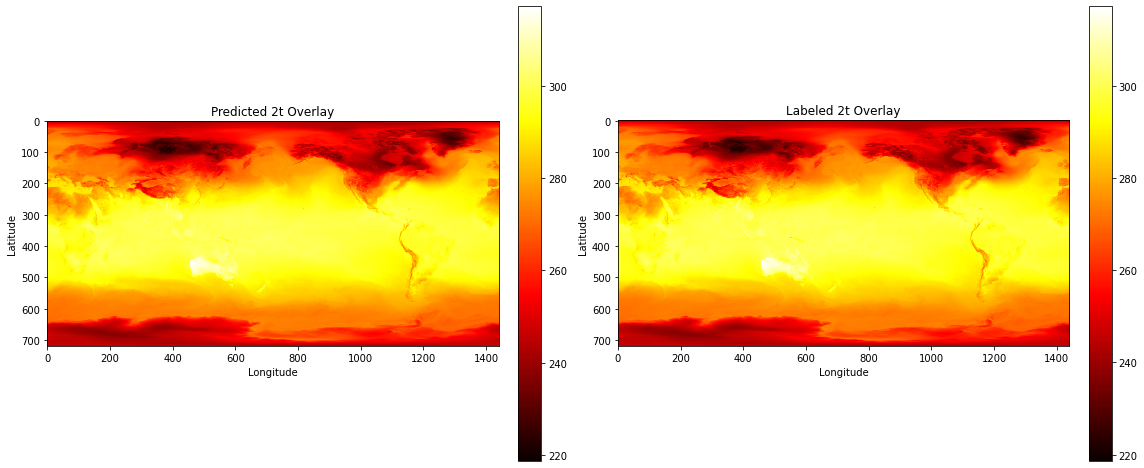

torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])


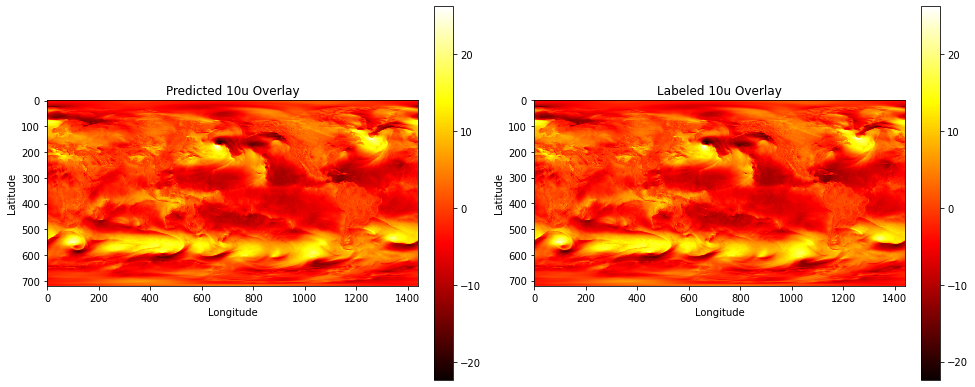

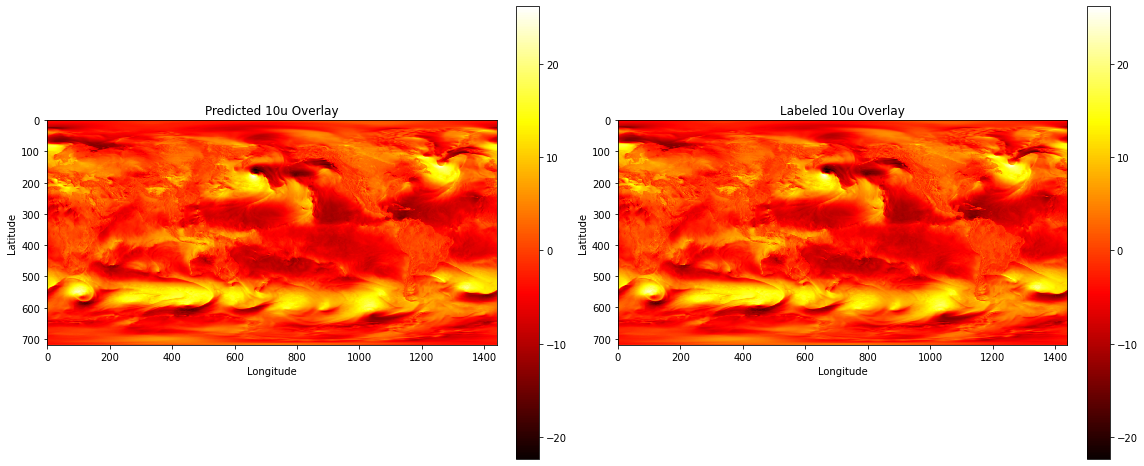

torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])


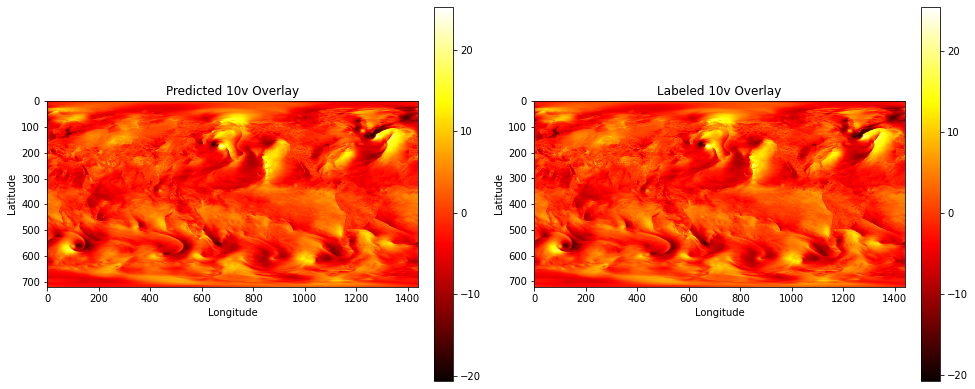

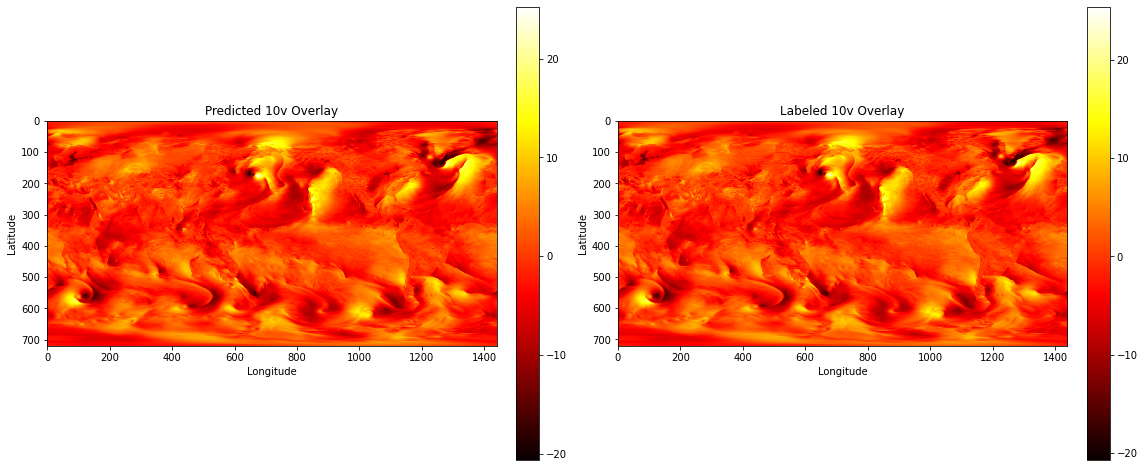

torch.Size([1, 1, 720, 1440])
torch.Size([1, 1, 720, 1440])


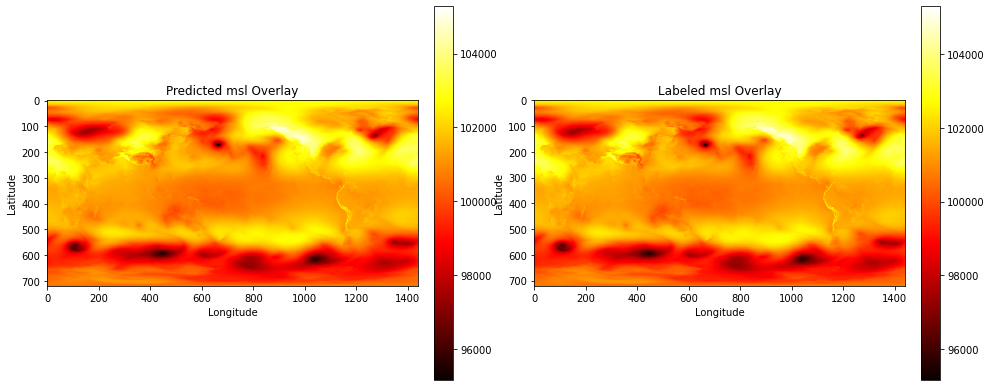

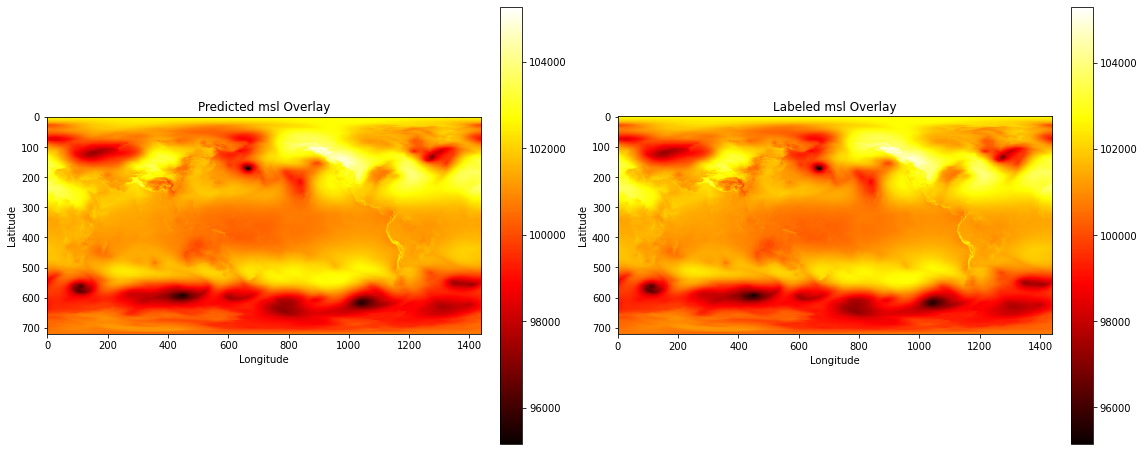

In [52]:

static_vars_ds = xr.open_dataset(f"../{download_path}/static/static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(f"../{download_path}/fle/surf_2015-01-04.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(f"../{download_path}/atmospheric/201501/atmospheric_20150104.nc", engine="netcdf4")


i = 0  # Select this time index in the downloaded data.
surf_size = (720, 1440)
atmos_size = (720, 1440)
output_size = (720, 1440)

surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[[i]][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[[ i]][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[[ i]][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[[ i]][None])
    }
atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[[ i]][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[[i]][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[[i]][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[[i]][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[[i]][None])
    }

interpolated_surf_vars = {
        key: (F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False) >= 0.5).int()
        if key == "fire" else  F.interpolate(value, size=surf_size, mode='bilinear', align_corners=False)
        for key, value in surf_vars.items()
    }
interpolated_surf_vars2 = {
        key: (F.interpolate(value, size=surf_size, mode='bicubic', align_corners=False) >= 0.5).int()
        if key == "fire" else  F.interpolate(value, size=surf_size, mode='bicubic', align_corners=False)
        for key, value in surf_vars.items()
    }
interpolated_atmos_vars = {
        key: F.interpolate(value.view(-1, 1, 721, 1440), size=atmos_size, mode='bilinear', align_corners=False).view(value.shape[0], value.shape[1], value.shape[2], 720, 1440)
        for key, value in atmos_vars.items()
    }



batch3 = Batch(
    surf_vars=surf_vars,
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars=atmos_vars,
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

print(interpolated_surf_vars['2t'].shape)
for var in interpolated_surf_vars.keys():
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    print(interpolated_surf_vars[var].shape)
    # Plot predicted grid for the current variable
    axes[0].imshow(interpolated_surf_vars[var].squeeze().squeeze(), cmap='hot', interpolation='nearest')
    axes[0].set_title(f'Predicted {var} Overlay')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

    # Plot labeled grid for the current variable
    axes[1].imshow(surf_vars[var].squeeze().squeeze(), cmap='hot', interpolation='nearest')
    axes[1].set_title(f'Labeled {var} Overlay')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    
    print(interpolated_surf_vars2[var].shape)
    # Plot predicted grid for the current variable
    axes[0].imshow(interpolated_surf_vars[var].squeeze().squeeze(), cmap='hot', interpolation='nearest')
    axes[0].set_title(f'Predicted {var} Overlay')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].colorbar = fig.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

    # Plot labeled grid for the current variable
    axes[1].imshow(surf_vars[var].squeeze().squeeze(), cmap='hot', interpolation='nearest')
    axes[1].set_title(f'Labeled {var} Overlay')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].colorbar = fig.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)

    # Show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
i = 0  # Select this time index in the downloaded data.

batch4 = Batch(
    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_comb["t2m"].values[[i - 1, i]][None]),
        "10u": torch.from_numpy(surf_comb["u10"].values[[i - 1, i]][None]),
        "10v": torch.from_numpy(surf_comb["v10"].values[[i - 1, i]][None]),
        "msl": torch.from_numpy(surf_comb["msl"].values[[i - 1, i]][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_comb["t"].values[[i - 1, i]][None]),
        "u": torch.from_numpy(atmos_comb["u"].values[[i - 1, i]][None]),
        "v": torch.from_numpy(atmos_comb["v"].values[[i - 1, i]][None]),
        "q": torch.from_numpy(atmos_comb["q"].values[[i - 1, i]][None]),
        "z": torch.from_numpy(atmos_comb["z"].values[[i - 1, i]][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_comb.latitude.values),
        lon=torch.from_numpy(surf_comb.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_comb.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_comb.pressure_level.values),
    ),
)

In [ ]:
from aurora import Aurora, rollout

model2 = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
model2.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

model2.eval()
model2 = model2.to("cuda")


In [ ]:

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model2, batch4, steps=2)]

model2 = model2.to("cpu")

# torch.stack(list(pred.surf_vars.values())).size()

In [ ]:
preds[1].surf_vars['2t'].size()